# SWB Regression Pipeline - Beta Power RPE + CPE


Created: 07/30/24 \
Updated: 09/30/2024 \
*ran with 1 sec regression dfs from 09/24/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2



In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



09302024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *



In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

# Load beta power data 

In [7]:
epoch_len = '1sec'
band = 'beta'

In [8]:
beta_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
beta_df.subj_id.unique()



array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [9]:
beta_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'ChoicePos', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'epoch', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type', 'cf',
       'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset',
       'reref_ch_names', 'band_pow', 'roi', 'hemi', 'unique_reref_ch'],
      dtype='object')

In [10]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()



roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [12]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     

keep_rois

['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [13]:
# ####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
# len(beta_reg_df)



# Electrode-wise Regressions + Permutations

In [14]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+rpe+cpe'
n_permutations = 1000


In [15]:
results_dict, main_var_sig = run_individual_elec_regression(beta_reg_df,reg_formula,elec_col, 
                                                            main_var,n_permutations)


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3495.78it/s]


In [20]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'rpe', 'cpe']

In [21]:
results = single_elec_permutation_results(results_dict,beta_reg_df,save_vars)
results



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.063369   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.060393   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.045752   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.005356   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.039432   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.029604   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.060391   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.008847   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                     0.014937   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                     0.103538   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.124831                   0.039962   
1                                  -0.082930                   0.014605   
2                                  -0.079425                   0.027509   
3                                  -0.017723                   0.066709   
4                                  -0.042780                  -0.008514   
...                                      ...                        ...   
1183                               -0.003784                   0.015244   
1184                                0.002055                   0.000567   
1185                               -0.126302                  -0.032957   
1186                               -0.050701                   0.029606   
1187                               -0.155446                  -0.033493   

      Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.062000               0.025399                -0.021168   
1                  0.101929              -0.036462                 0.003211   
2                  0.068575               0.042041                -0.008609   
3                 -0.058730               0.062281                -0.006273   
4                  0.002768               0.018903                 0.009625   
...                     ...                    ...                      ...   
1183               0.054160              -0.015095                 0.027707   
1184               0.047038               0.002334                 0.060061   
1185               0.002633               0.055097                -0.059281   
1186              -0.026433               0.067630                -0.002975   
1187               0.031257               0.120575                 0.040778   

      ...  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  \
0     ...           2.841389                     -2.844245         0.968568   
1     ...           2.039764                     -2.050230         0.368815   
2     ...           1.893929                     -1.892153         0.763914   
3     ...           0.420690                     -0.418872         1.799250   
4     ...           1.005566                     -1.002115        -0.267876   
...   ...                ...                           ...              ...   
1183  ...           0.107883                     -0.123968         0.369438   
1184  ...           0.014637                      0.005586        -0.010695   
1185  ...           2.642734                     -2.780800        -0.725548   
1186  ...           1.016368                     -1.249902         0.721071   
1187  ...           2.597130                     -2.750466        -0.580763   

      Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0        1.342556     0.617586           0.004492   
1        2.414193    -0.901653           0.041374   
2        1.655116     1.050615           0.058234   
3       -1.388609     1.394239           0.673981   
4        0

In [22]:
results.columns



Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TrialEV', 'Original_Estimate_rpe',
       'Original_Estimate_cpe', 'Permuted_Mean_Intercept',
       'Permuted_Mean_GambleChoice[T.safe]', 'Permuted_Mean_TrialEV',
       'Permuted_Mean_rpe', 'Permuted_Mean_cpe', 'Permuted_Std_Intercept',
       'Permuted_Std_GambleChoice[T.safe]', 'Permuted_Std_TrialEV',
       'Permuted_Std_rpe', 'Permuted_Std_cpe', 'Z_Score_Intercept',
       'Z_Score_GambleChoice[T.safe]', 'Z_Score_TrialEV', 'Z_Score_rpe',
       'Z_Score_cpe', 'P_Value_Intercept', 'P_Value_GambleChoice[T.safe]',
       'P_Value_TrialEV', 'P_Value_rpe', 'P_Value_cpe'],
      dtype='object')

In [23]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_errormodel_rpe_cpe_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# CPE Coefficients

In [24]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
12      MS002_laims1-laims2   MS002   ains   14                     0.350995   
16      MS002_laims5-laims6   MS002   ains   14                     0.203514   
20    MS002_laims12-laims13   MS002  dmpfc   14                     0.084854   
26      MS002_lloif1-lloif2   MS002    ofc   14                     0.172635   
60      MS002_raims3-raims4   MS002   ains   14                     0.264282   
...                     ...     ...    ...  ...                          ...   
1171        DA039_rfp6-rfp7   DA039    ofc   22                    -0.098471   
1175        DA039_rof4-rof5   DA039    ofc   22                    -0.083522   
1177        DA039_rof6-rof7   DA039  dlpfc   22                    -0.017226   
1178        DA039_rof7-rof8   DA039  vlpfc   22                    -0.016649   
1180       DA039_rof9-rof10   DA039  dlpfc   22                     0.021893   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
12                                 -0.333621                  -0.043655   
16                                 -0.166261                  -0.024266   
20                                 -0.104507                  -0.016156   
26                                 -0.203463                  -0.061305   
60                                 -0.290284                   0.000543   
...                                      ...                        ...   
1171                                0.033382                   0.002111   
1175                                0.036174                   0.019316   
1177                               -0.052491                   0.010704   
1178                               -0.043990                   0.038202   
1180                               -0.015979                   0.070430   

      Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  \
12                -0.057598               0.139637                 0.120160   
16                 0.007743               0.133196                 0.089283   
20                -0.022577               0.092393                 0.011794   
26                -0.082301               0.113230                 0.029017   
60                -0.036786               0.124764                 0.064459   
...                     ...                    ...                      ...   
1171               0.027625              -0.028763                -0.085660   
1175               0.035128              -0.040084                -0.069147   
1177              -0.049183               0.076532                -0.036740   
1178              -0.137221               0.133731                -0.029286   
1180              -0.058672               0.156868                 0.021562   

      ...  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  \
12    ...           4.745560                     -4.733784        -0.637858   
16    ...           2.847935                     -2.833483        -0.425173   
20    ...           2.341951                     -2.328651        -0.429999   
26    ...           3.693610                     -3.678001        -1.255605   
60    ...           4.709847                     -4.701556        -0.032463   
...   ...                ...                           ...              ...   
1171  ...          -2.811891                      3.145597         0.198207   
1175  ...          -2.034520                      2.145334         1.226173   
1177  ...           1.529857                     -1.799121         0.318664   
1178  ...           0.740798                     -1.098785         0.961149   
1180  ...           0.016765                     -0.361552         1.526513   

      Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
12      -0.849559     2.033320           0.000002   
16       0.147845     2.234243           0.004400   
20      -0.497582     2.052029           0.019183   
26      -1.512696     2.031620           

In [25]:
sig_data.roi.value_counts()



roi
ofc      12
dmpfc    10
ains      9
dlpfc     9
acc       8
pins      7
amy       6
vlpfc     4
hpc       3
Name: count, dtype: int64

In [26]:
sig_data.roi.unique()



array(['ains', 'dmpfc', 'ofc', 'pins', 'vlpfc', 'amy', 'hpc', 'acc',
       'dlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [27]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.063369   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.060393   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.045752   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.005356   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.039432   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.124831                   0.039962   
1                               -0.082930                   0.014605   
2                               -0.079425                   0.027509   
3                               -0.017723                   0.066709   
4                               -0.042780                  -0.008514   

   Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  ...  \
0               0.062000               0.025399                -0.021168  ...   
1               0.101929              -0.036462                 0.003211  ...   
2               0.068575               0.042041                -0.008609  ...   
3              -0.058730               0.062281                -0.006273  ...   
4               0.002768               0.018903                 0.009625  ...   

   Z_Score_TrialEV  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0         0.968568     1.342556     0.617586           0.004492   
1         0.368815     2.414193    -0.901653           0.041374   
2         0.763914     1.655116     1.050615           0.058234   
3         1.799250    -1.388609     1.394239           0.673981   
4        -0.267876     0.045856     0.490302           0.314624   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_rpe  P_Value_cpe  \
0                      0.004452         0.332761     0.179416     0.536849   
1                      0.040342         0.712265     0.015770     0.367241   
2                      0.058471         0.444919     0.097901     0.293435   
3                      0.675310         0.071979     0.164952     0.163245   
4                      0.316288         0.788795     0.963425     0.623920   

   cpe_sig  bdi_split  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0  

[5 rows x 31 columns]

In [28]:
cpe_var = 'Z_Score_cpe'

In [29]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [30]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc    0.135095
vlpfc    0.237668
dmpfc    0.085644
ofc     -0.018992
ains     0.540765
pins     0.430172
acc      0.047528
amy     -0.122973
hpc      0.184485
Name: Z_Score_cpe, dtype: float64

In [31]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [32]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193      8  0.041451              2    0.678572    0.498226   
1  dmpfc      225     10  0.044444              2    1.383124    0.168004   
2    amy      113      6  0.053097              1   -1.278855    0.203591   
3   ains       71      9  0.126761              0    3.874480    0.000238   
4  vlpfc       82      4  0.048780              2    2.018874    0.046809   
5    hpc      135      3  0.022222              0    2.227792    0.027562   
6    ofc      202     12  0.059406              4   -0.257949    0.796710   
7   pins       60      7  0.116667              1    2.768395    0.007516   
8  dlpfc      107      9  0.084112              3    1.227230    0.222455   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.020790            1.0    0.041451      0.7534  
1      0.024308            1.0    0.044444      0.6920  
2      0.023374            1.0    0.053097      0.4994  
3      0.067750            1.0    0.126761      0.0088  
4      0.016832            1.0    0.048780      0.5912  
5      0.006084            1.0    0.022222      0.9674  
6      0.034632            1.0    0.059406      0.3119  
7      0.056055            1.0    0.116667      0.0297  
8      0.044581            1.0    0.084112      0.0880

In [33]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
3  ains       71      9  0.126761              0    3.874480    0.000238   
7  pins       60      7  0.116667              1    2.768395    0.007516   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
3      0.067750            1.0    0.126761      0.0088  
7      0.056055            1.0    0.116667      0.0297

# Plot Results

In [34]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_errormodel_cpe_coeff_barplot_{epoch_len}.pdf'

ylabel = fr'${band}_{{zpow}} \sim cpe$'

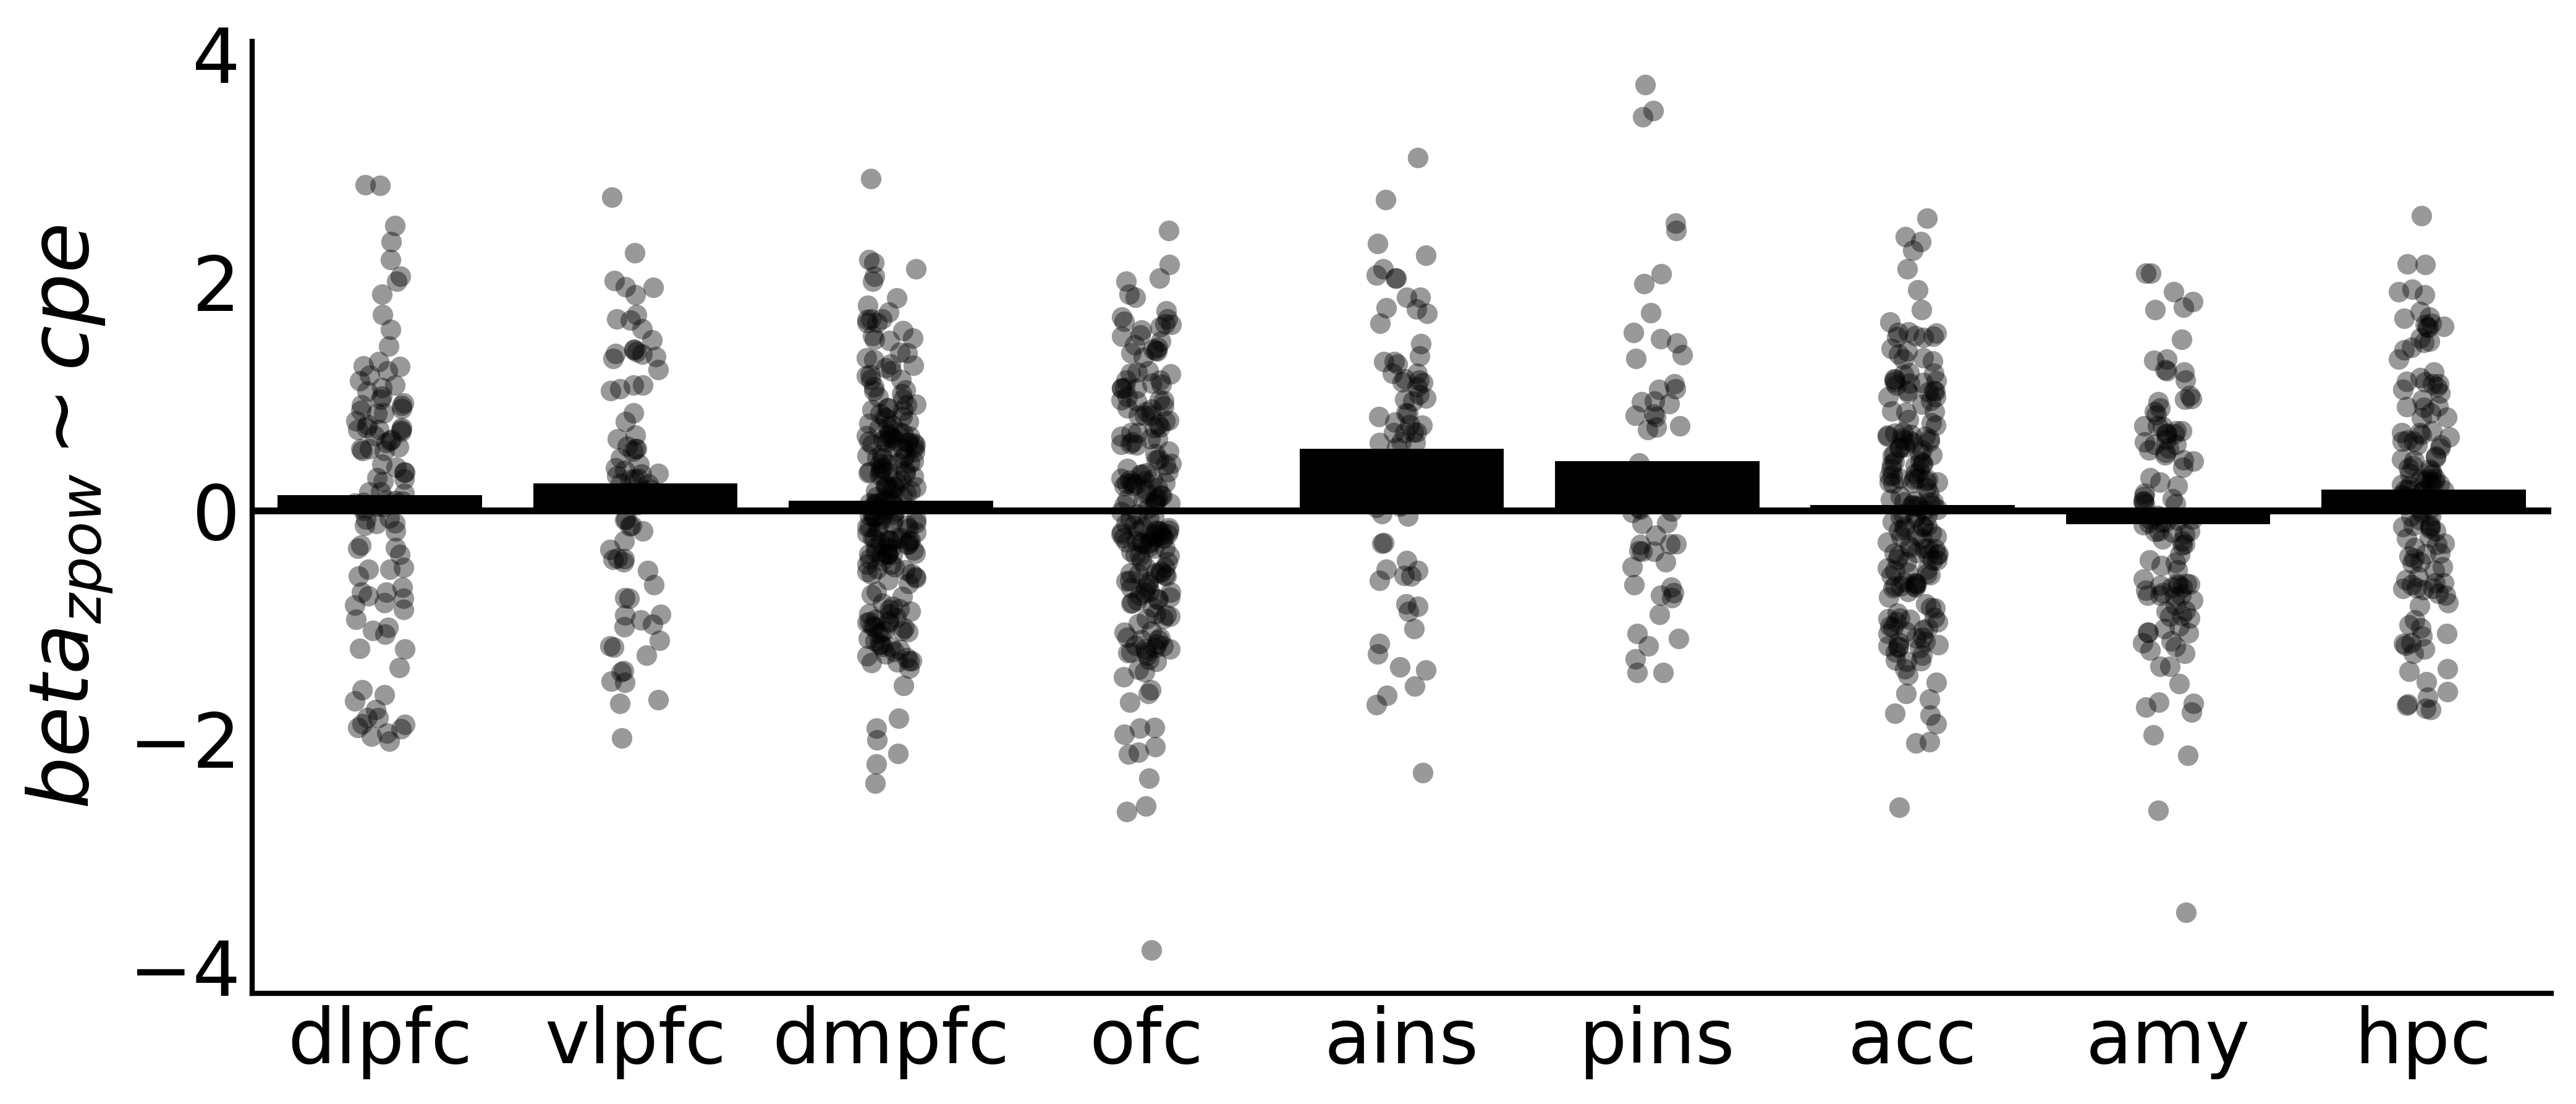

In [35]:
### WITH RPE IN MODEL

plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

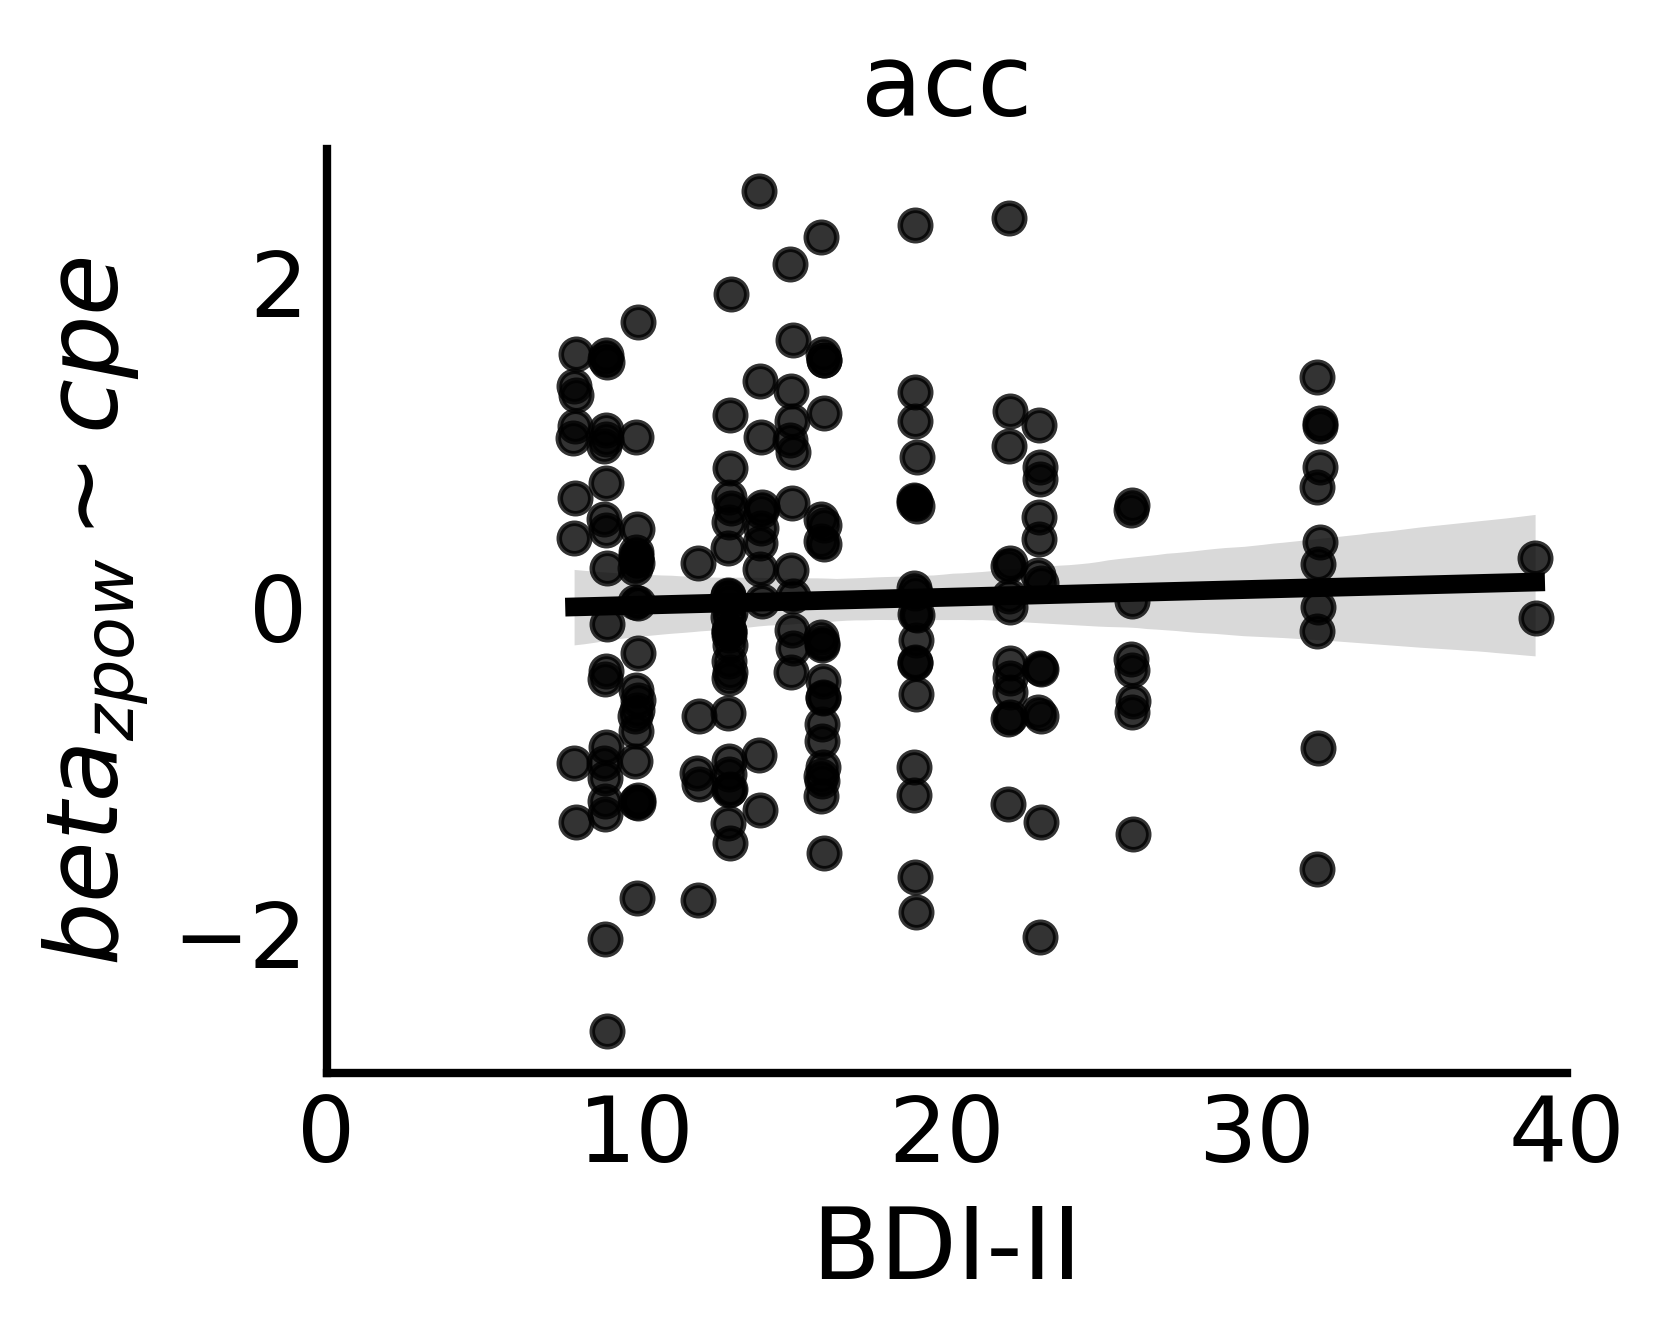

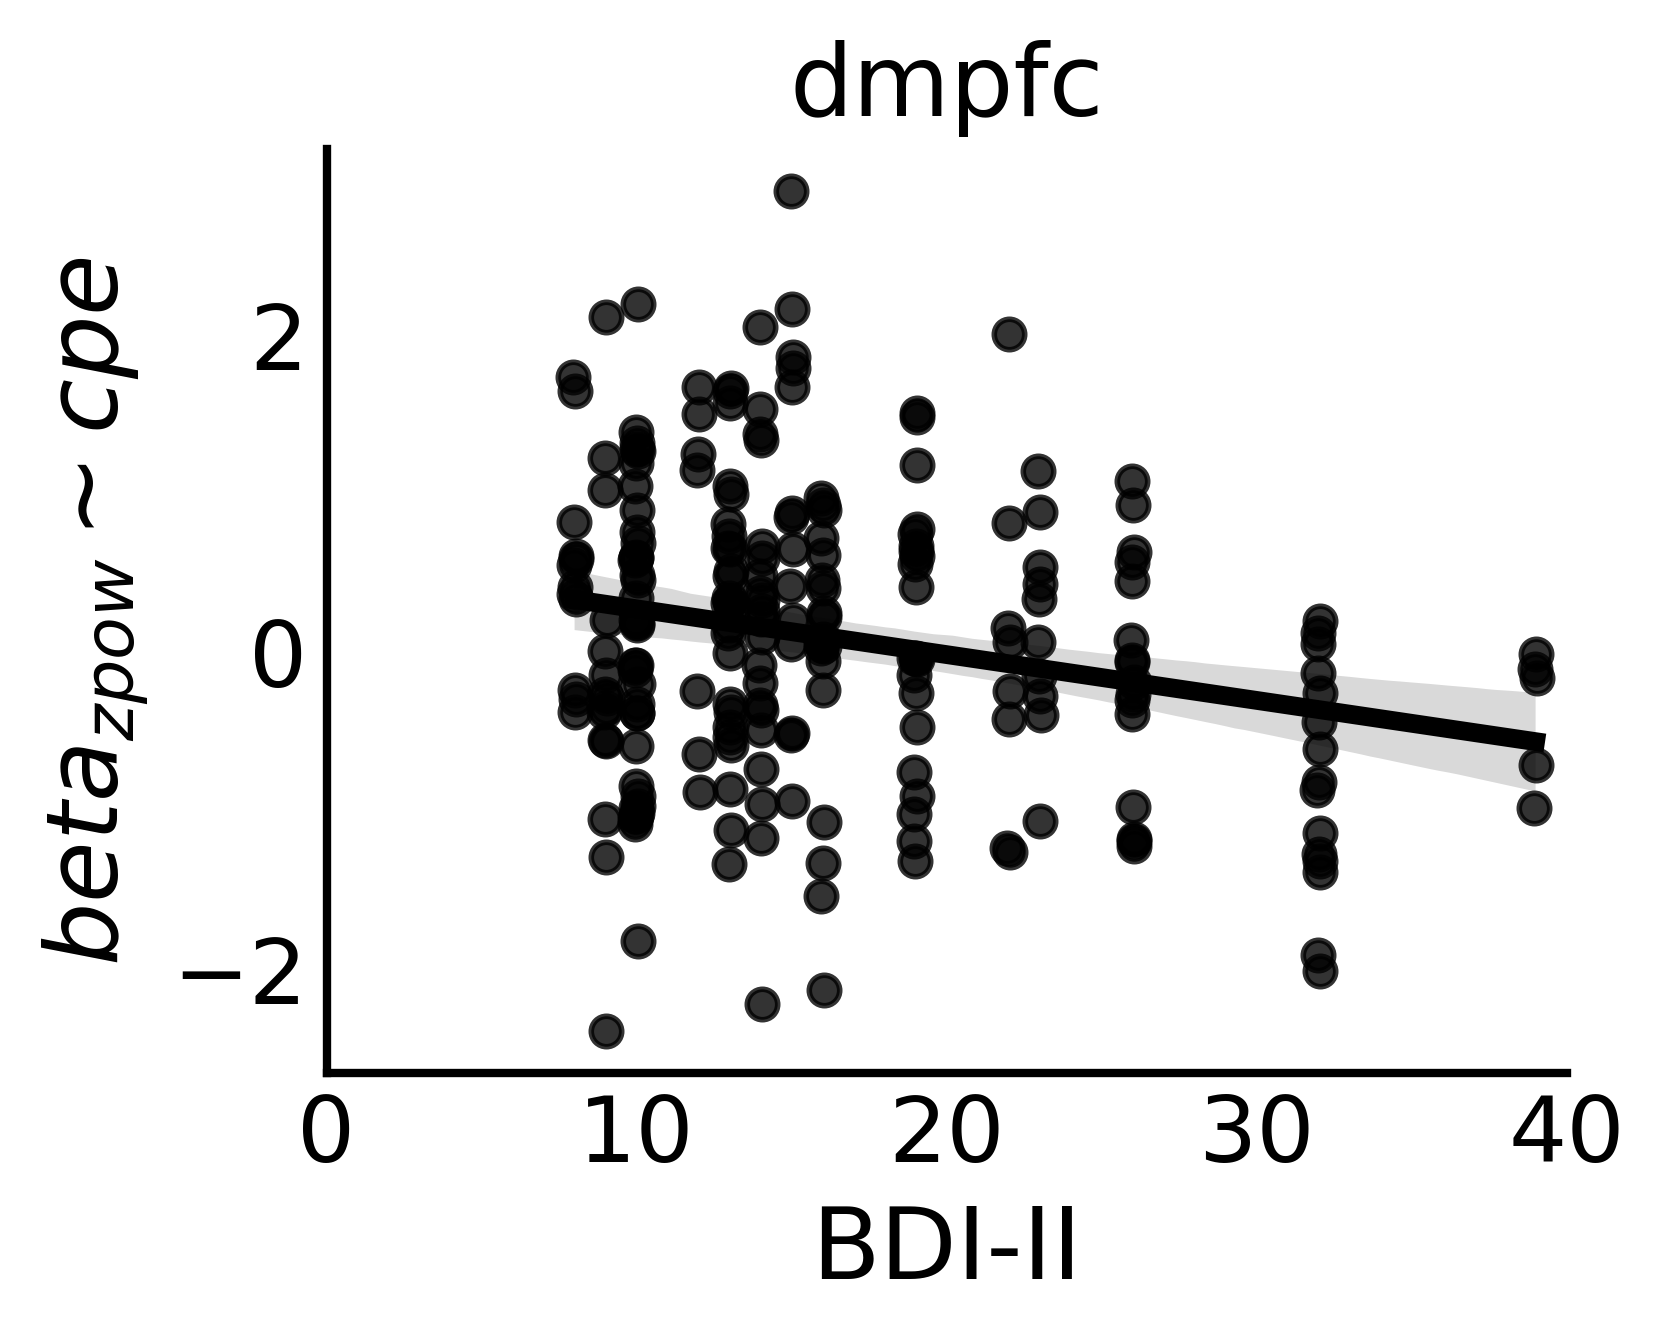

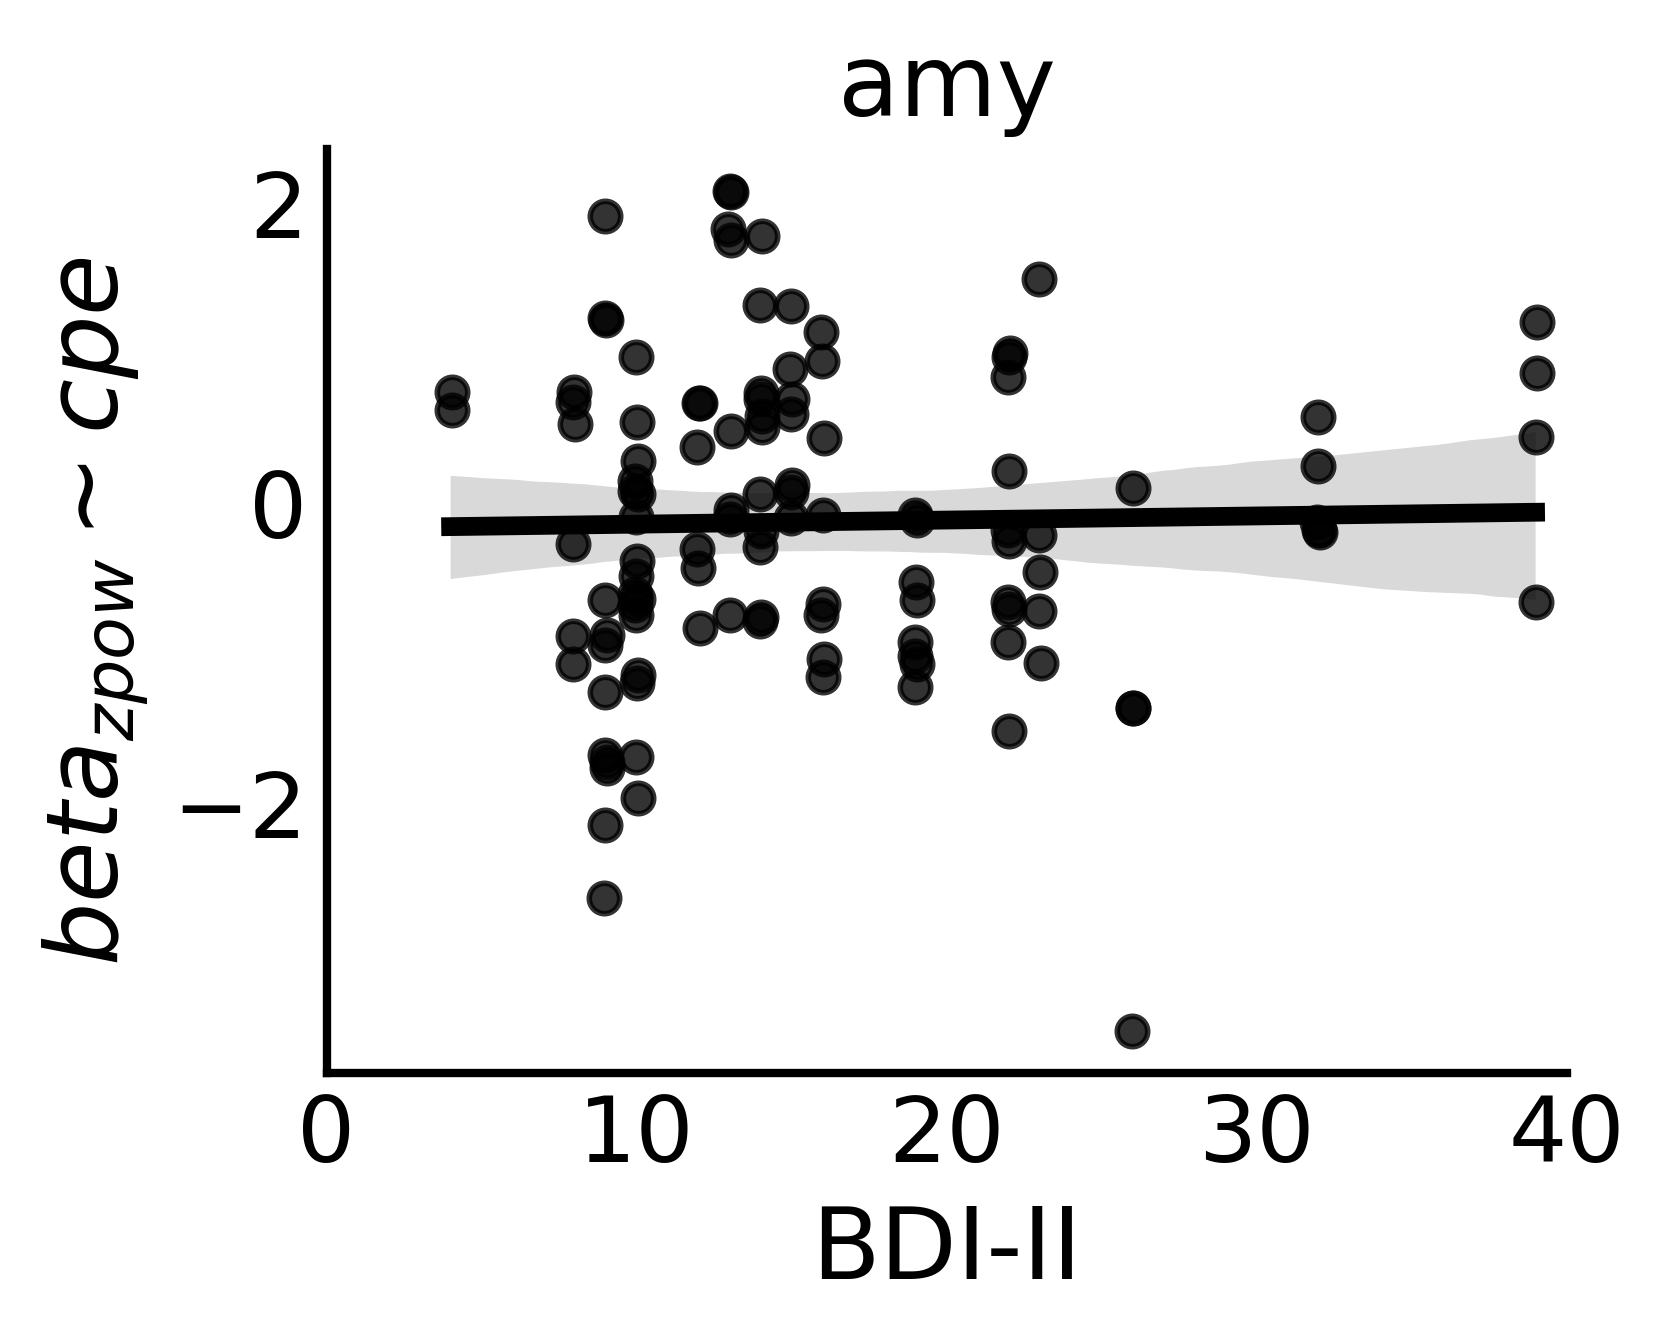

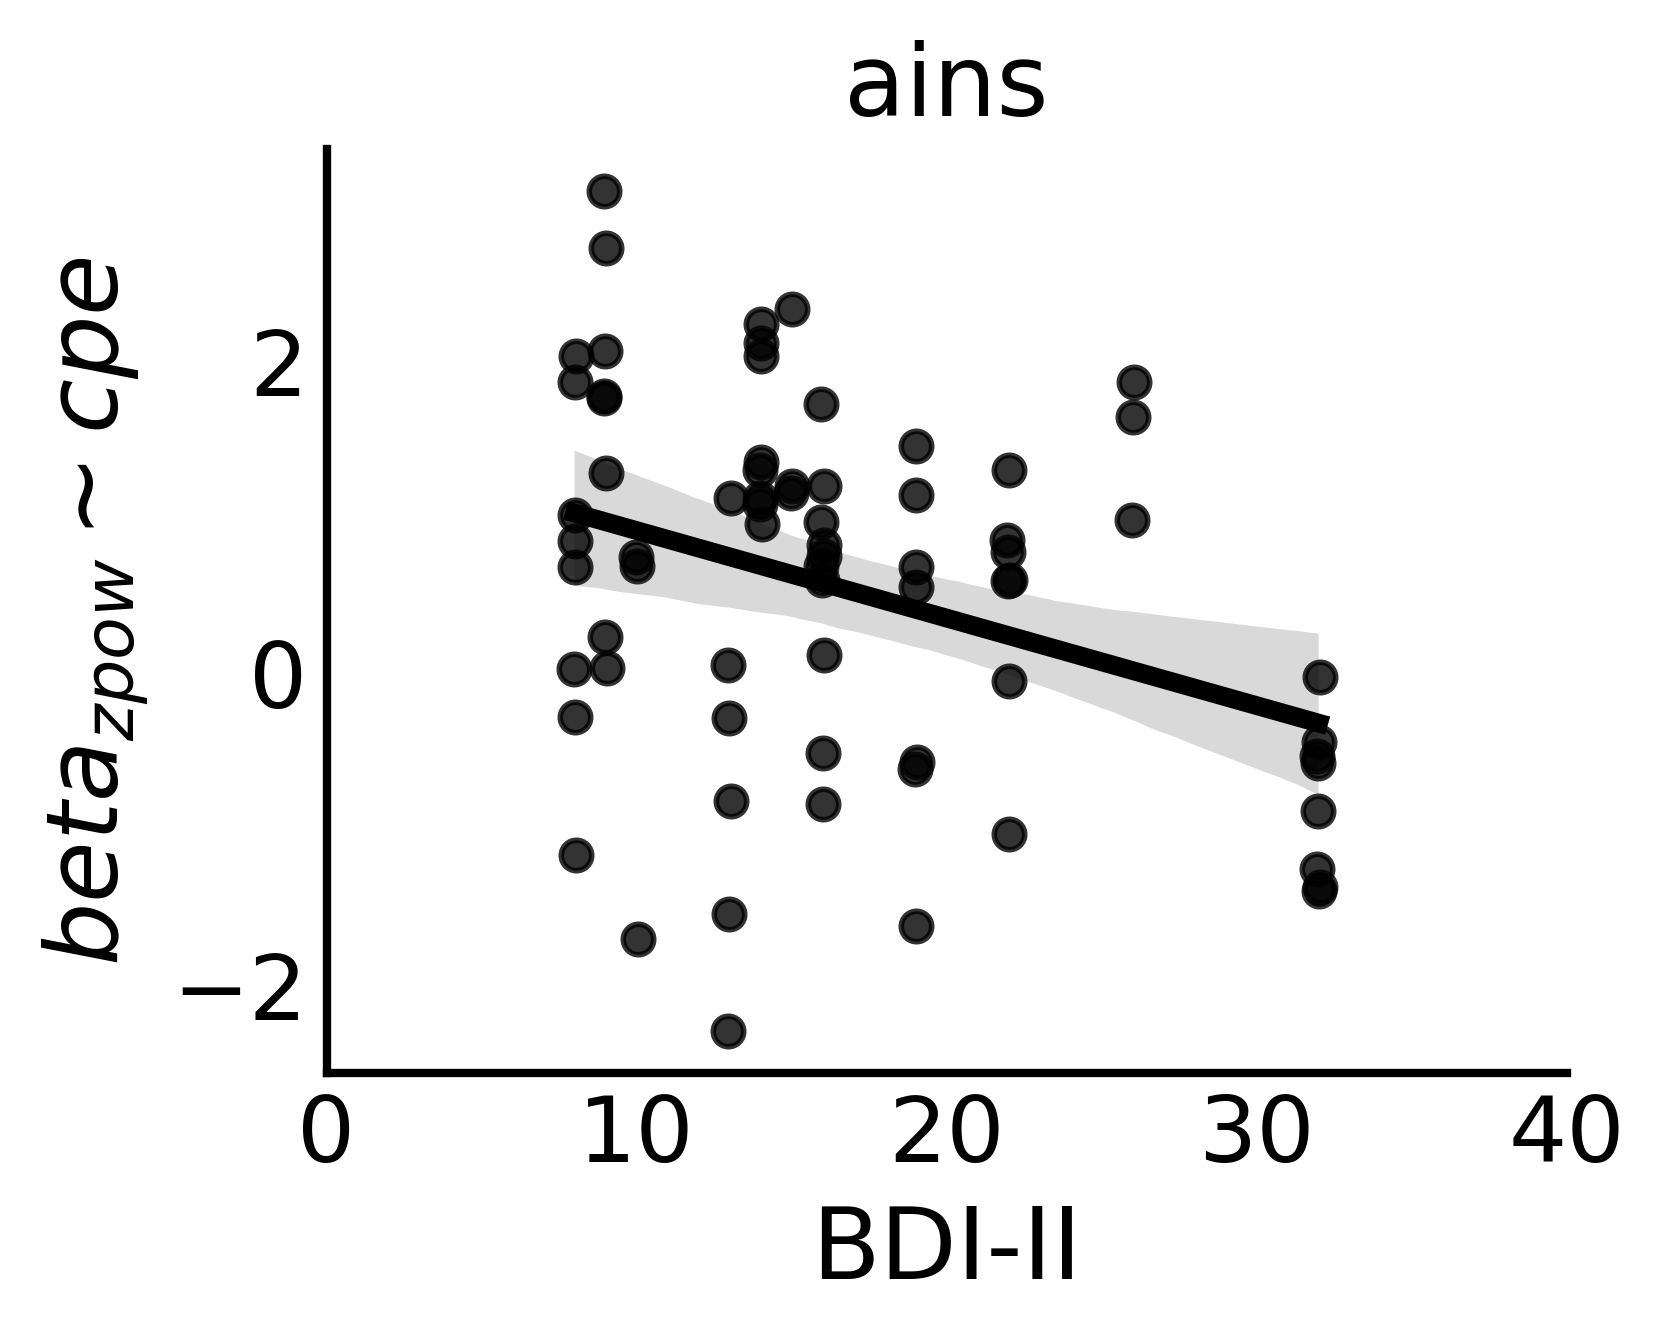

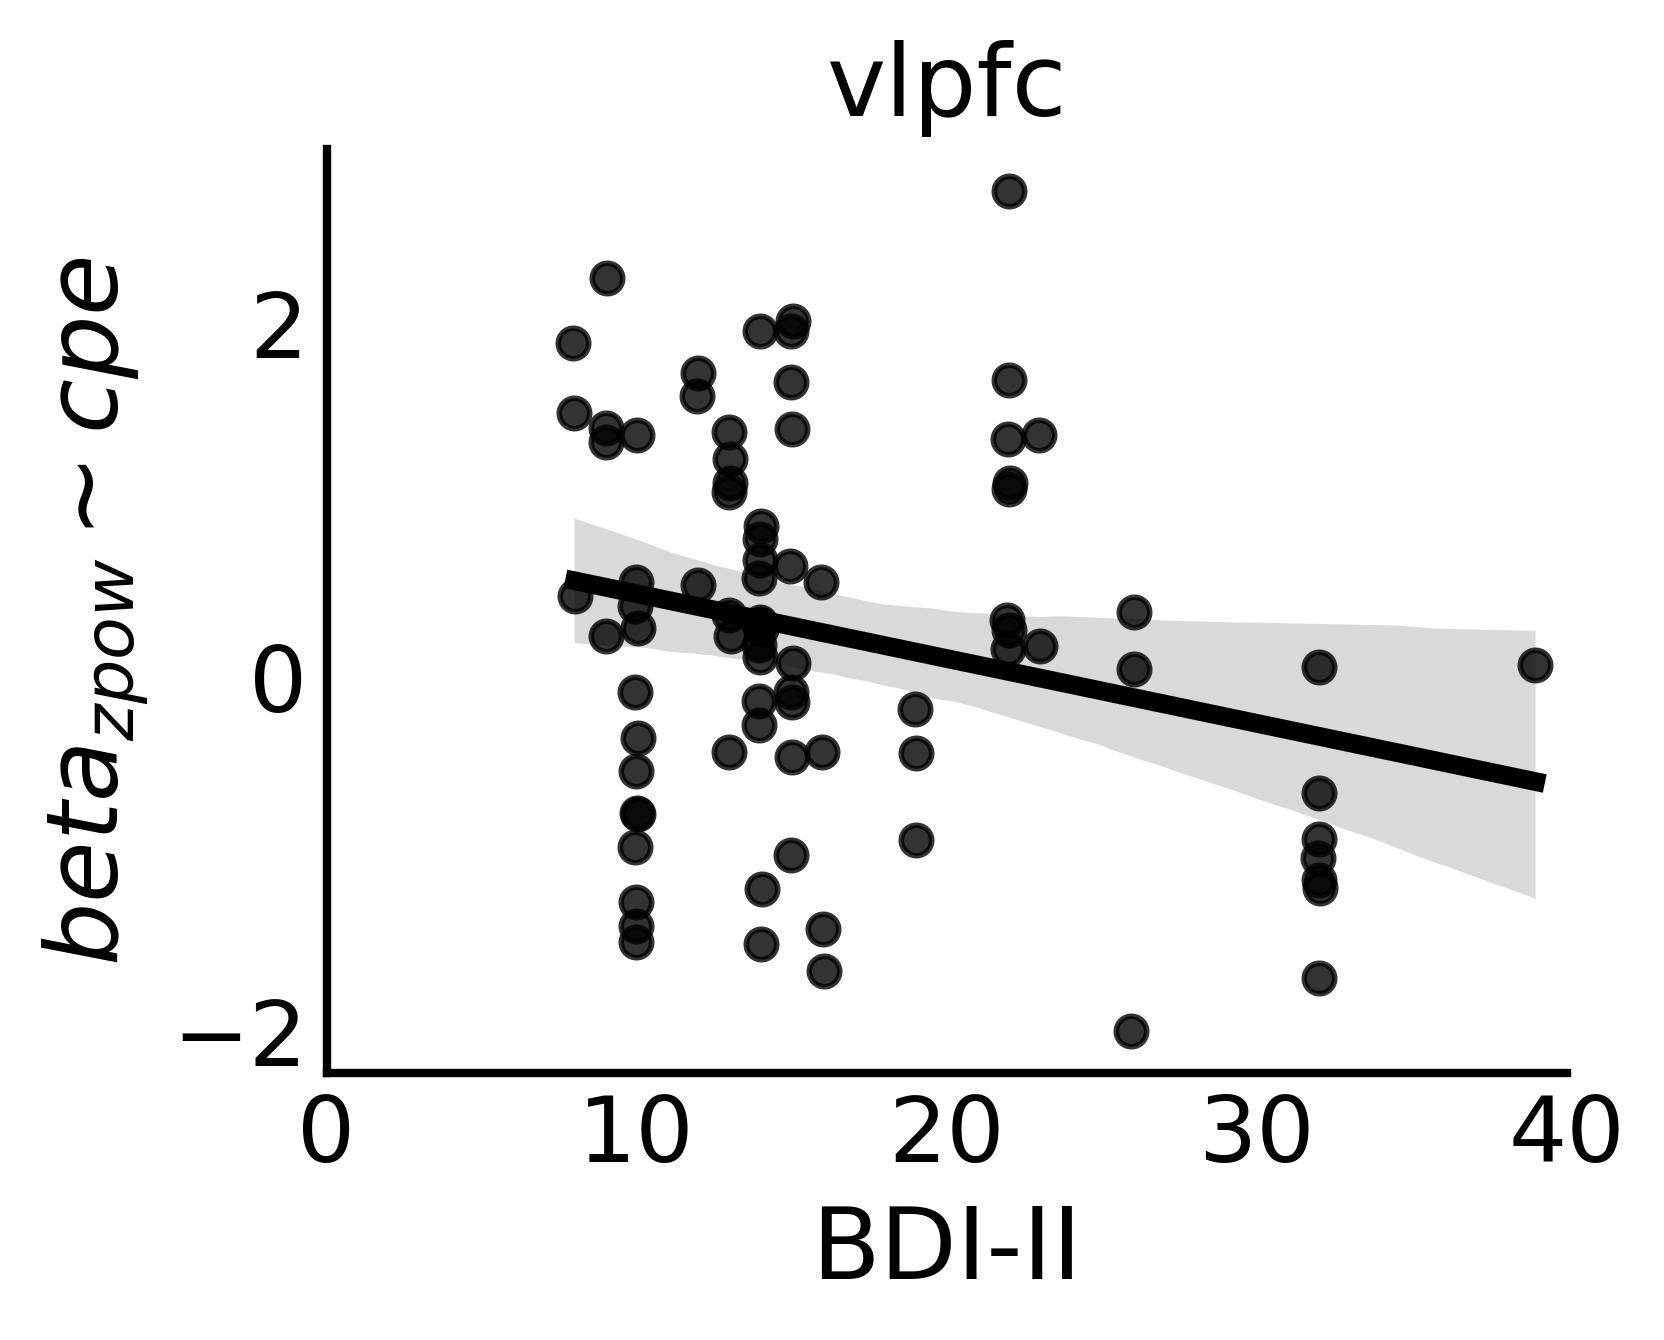

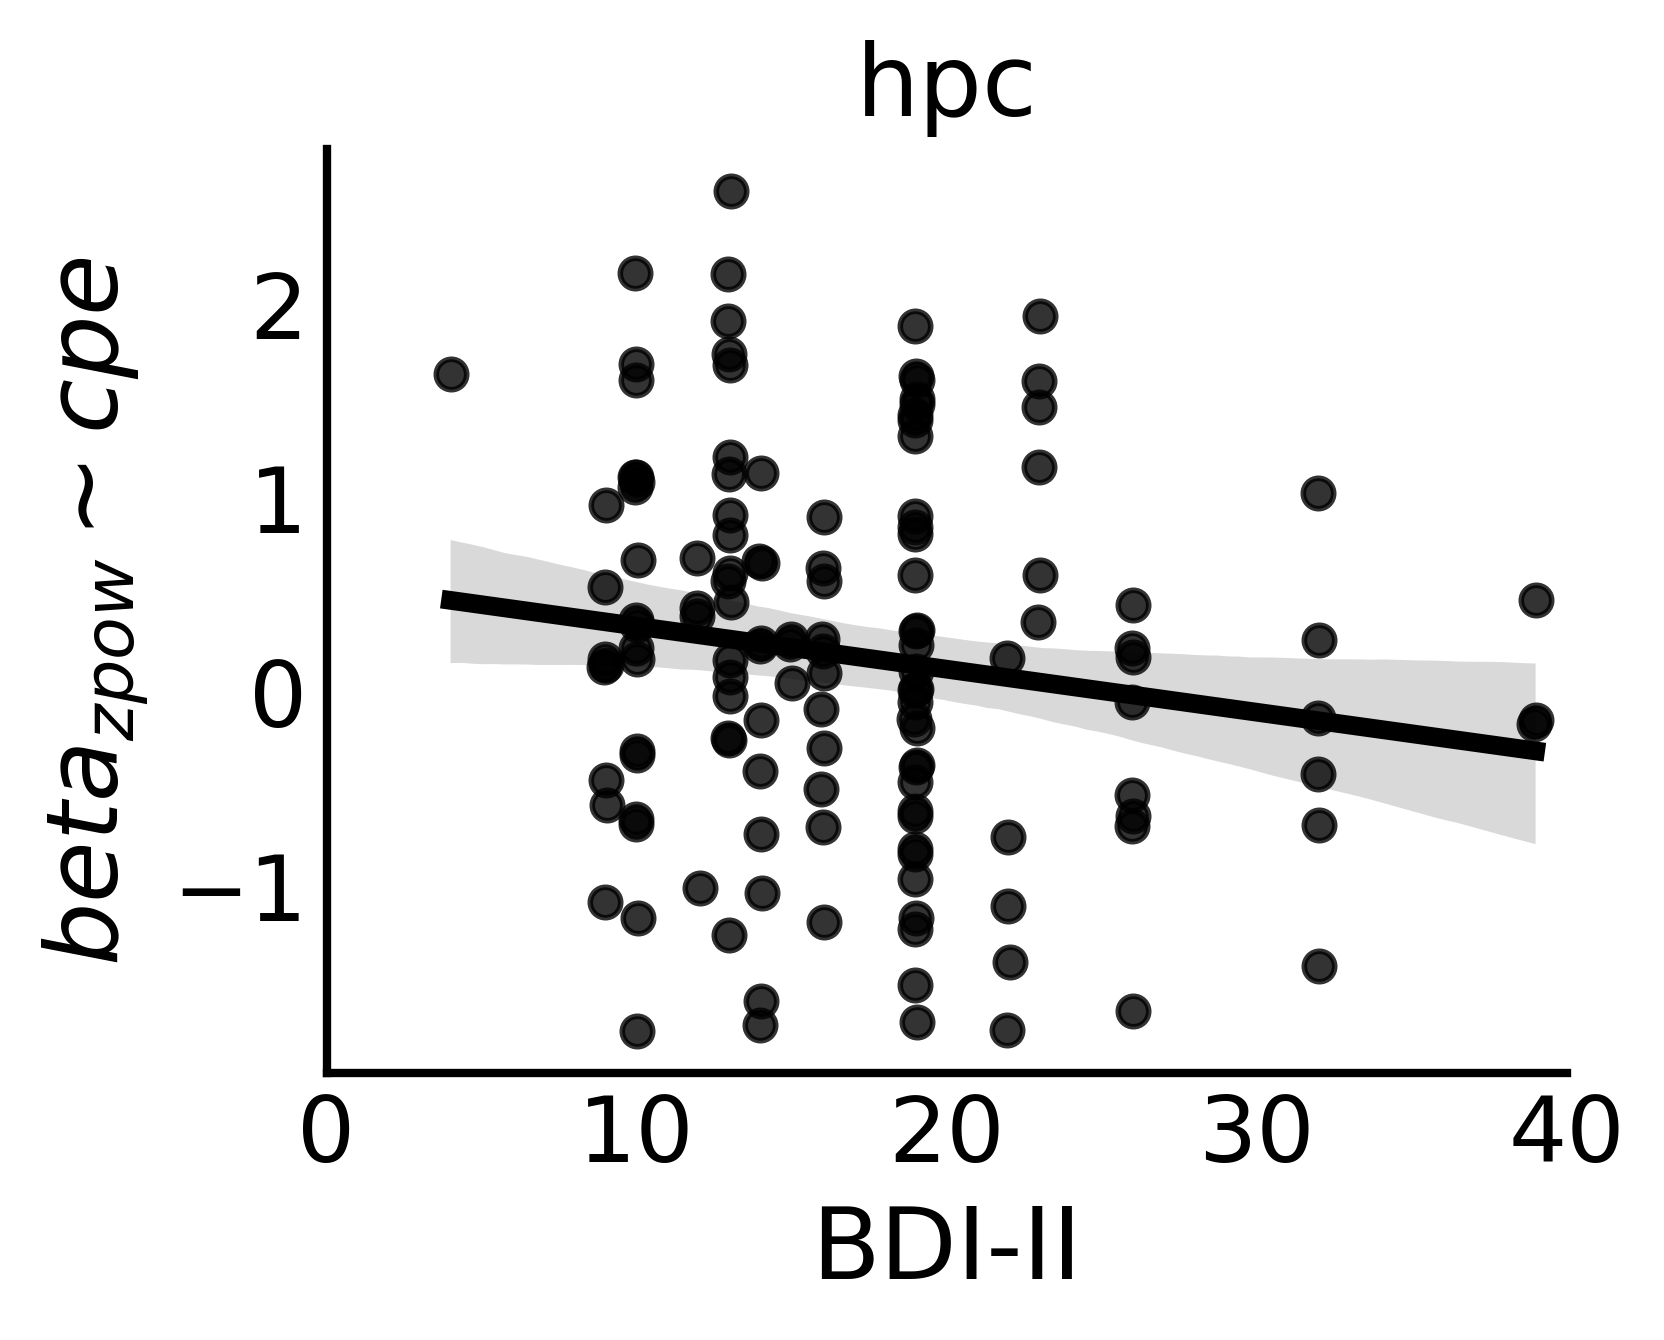

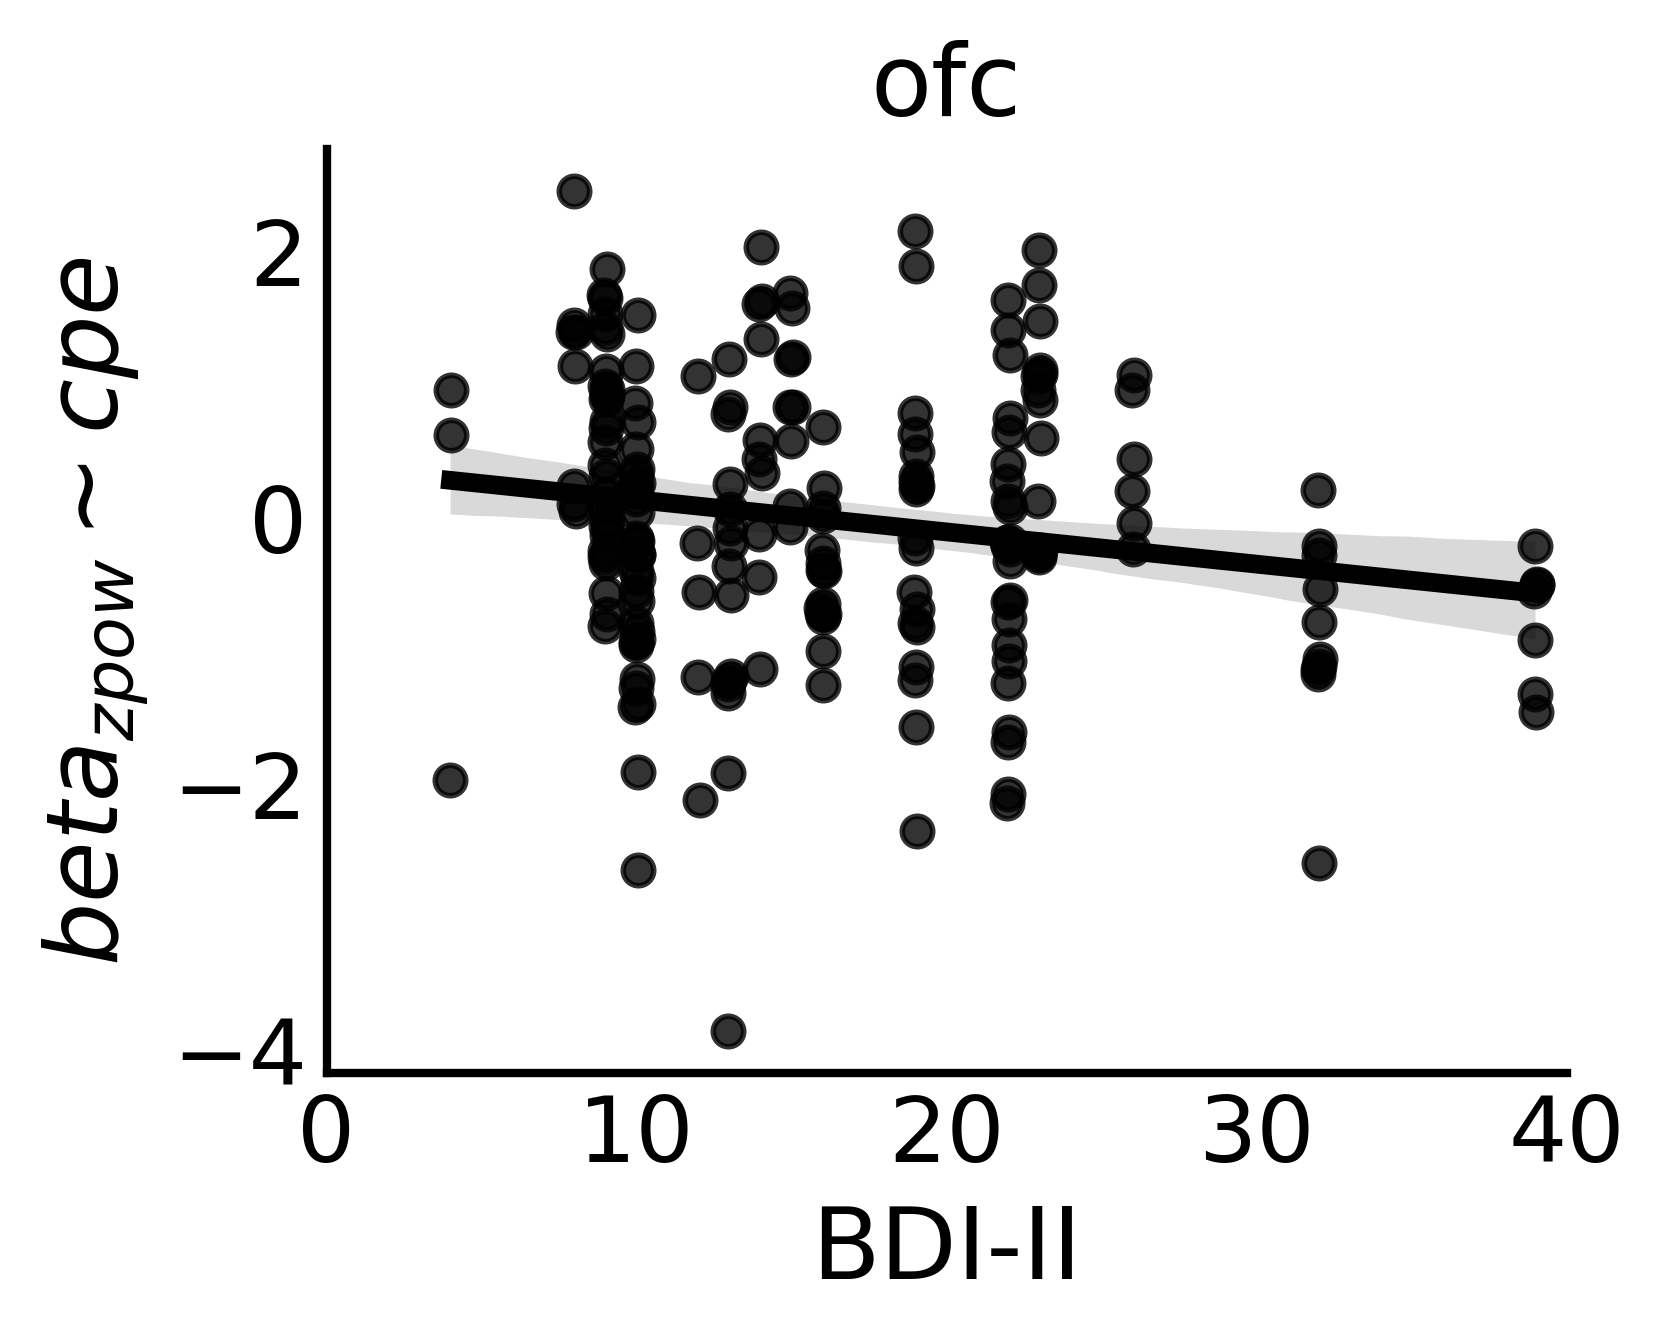

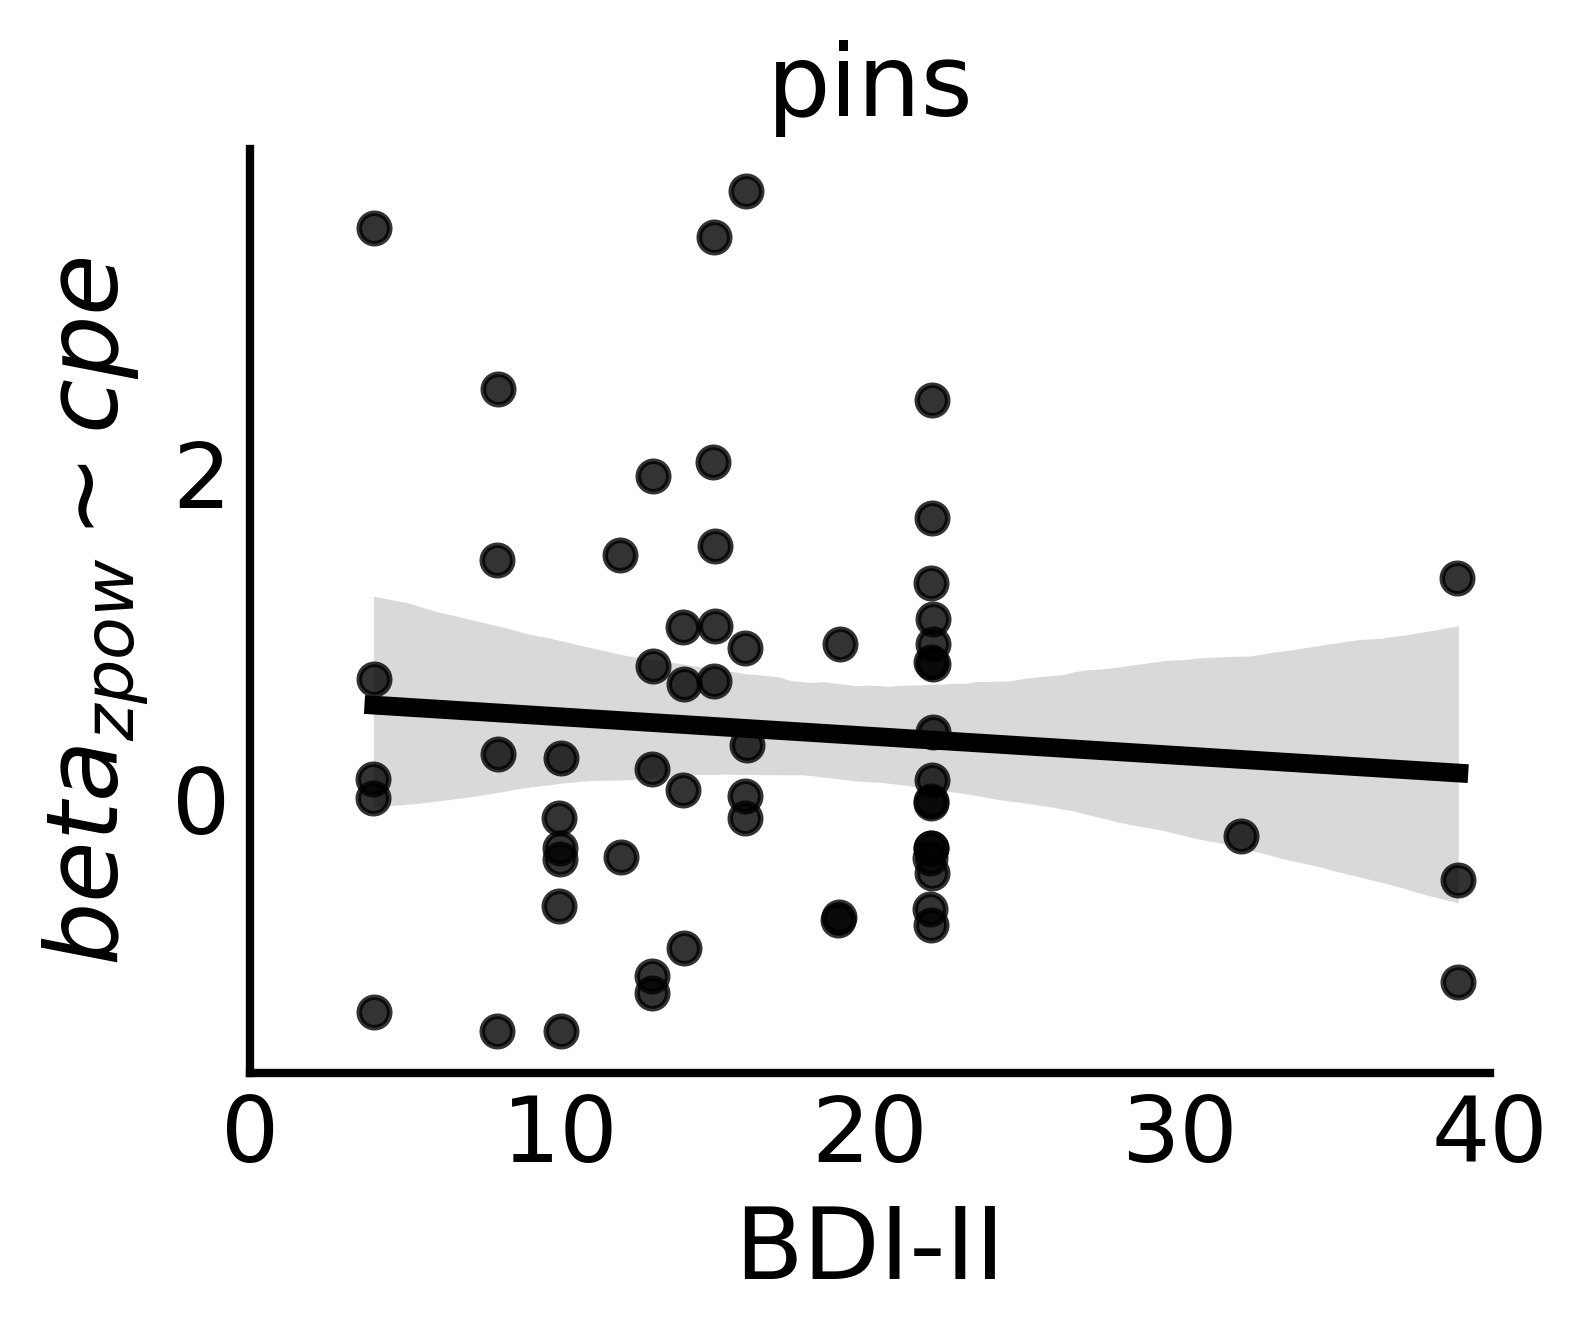

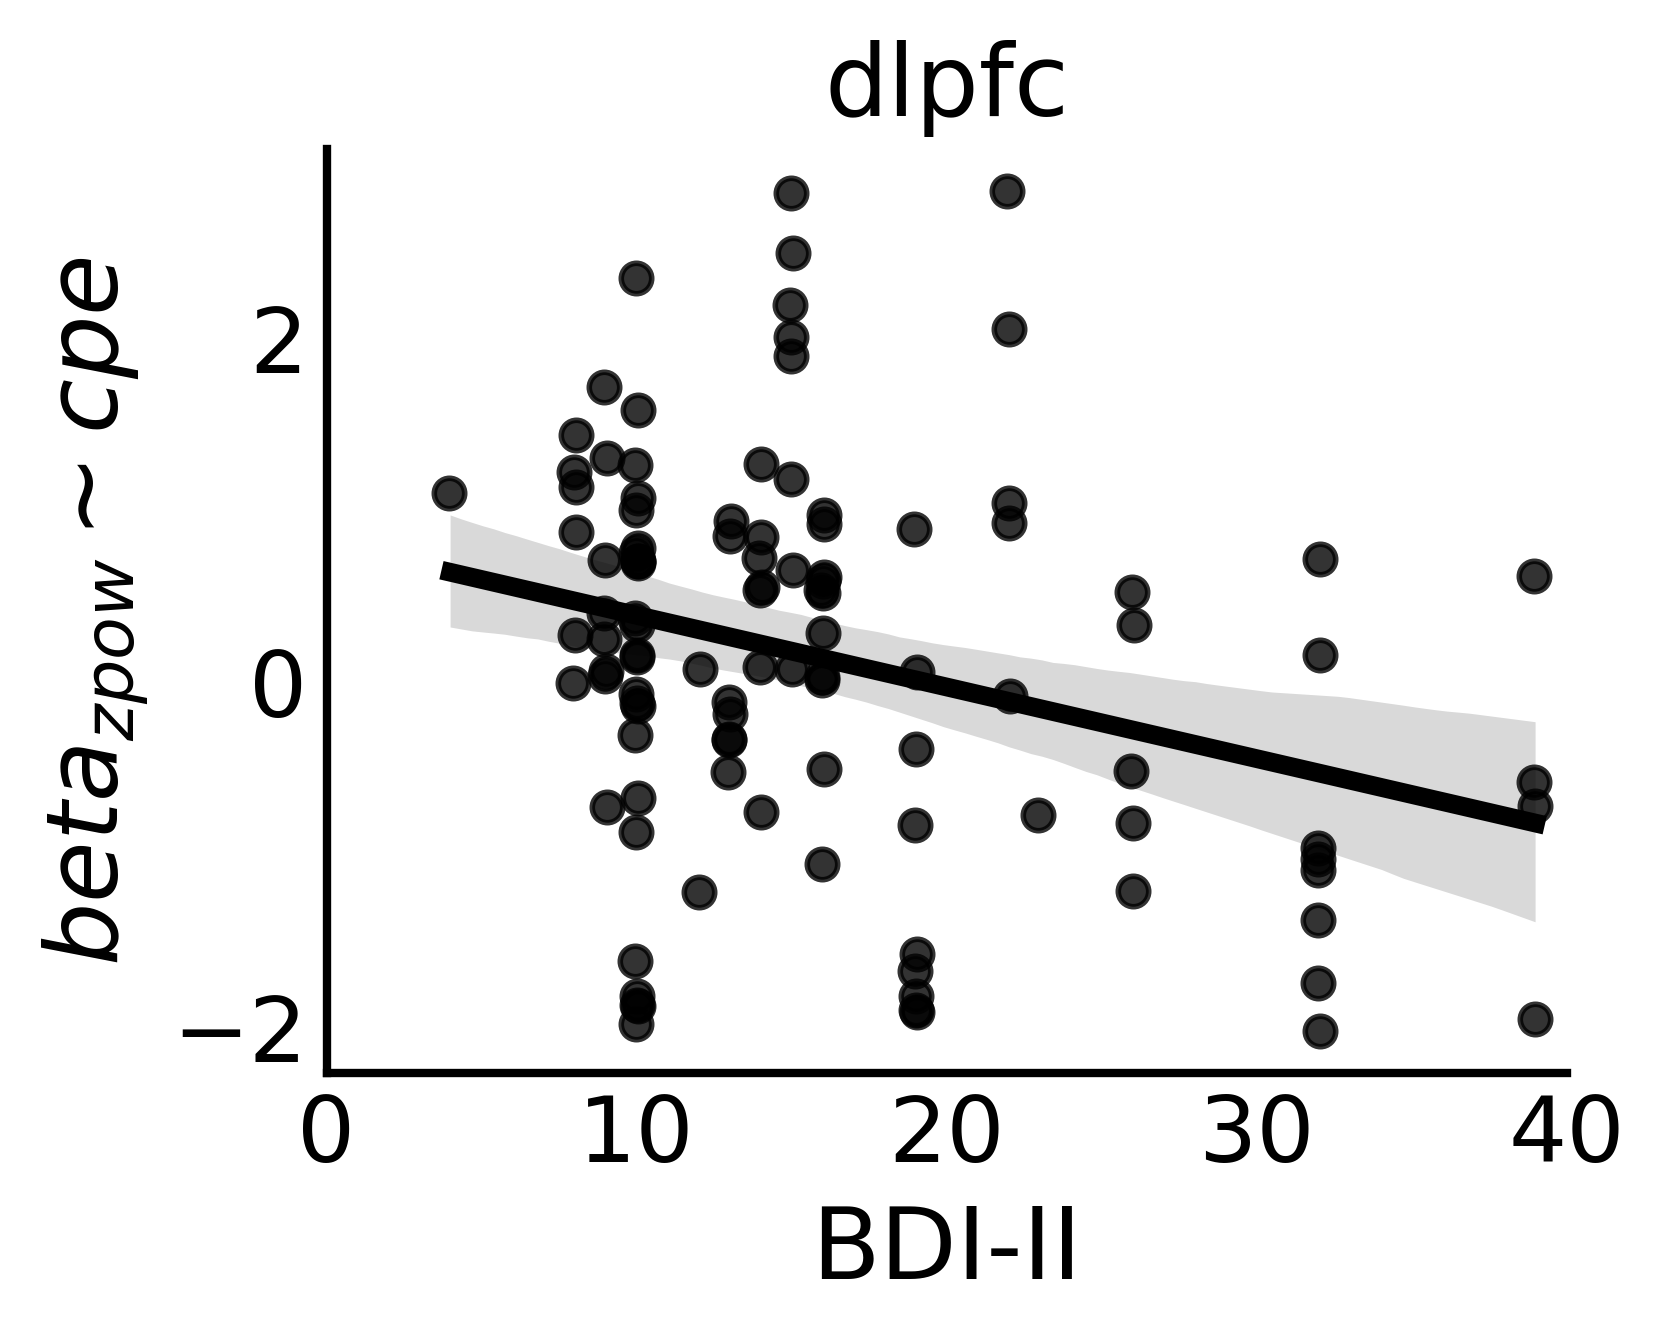

In [36]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_errormodel_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [37]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        20:31:55                                         
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9121      0.447     35.577     

In [41]:
# del cpe_var

# RPE Coefficients

In [38]:
sig_data = results[results.P_Value_rpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
1     MS002_lacas2-lacas3   MS002    acc   14                     0.060393   
33    MS002_lmoif8-lmoif9   MS002  vlpfc   14                     0.148566   
39    MS002_lpips2-lpips3   MS002   pins   14                     0.004166   
46      MS002_lsif3-lsif4   MS002  vlpfc   14                    -0.128434   
48    MS002_racas1-racas2   MS002    acc   14                    -0.014122   
...                   ...     ...    ...  ...                          ...   
1082  MS050_ragit3-ragit4   MS050    amy    9                    -0.029936   
1143      DA037_rhh1-rhh2   DA037    hpc    4                    -0.030322   
1147      DA037_rof3-rof4   DA037    ofc    4                    -0.166602   
1171      DA039_rfp6-rfp7   DA039    ofc   22                    -0.098471   
1178      DA039_rof7-rof8   DA039  vlpfc   22                    -0.016649   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
1                                  -0.082930                   0.014605   
33                                 -0.242220                  -0.058295   
39                                 -0.041068                  -0.042089   
46                                 -0.041091                   0.011053   
48                                 -0.008617                  -0.008502   
...                                      ...                        ...   
1082                               -0.053130                   0.004161   
1143                               -0.012261                   0.064818   
1147                                0.060959                   0.027429   
1171                                0.033382                   0.002111   
1178                               -0.043990                   0.038202   

      Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  \
1                  0.101929              -0.036462                 0.003211   
33                 0.161933              -0.067739                -0.021105   
39                -0.086909               0.030758                -0.024221   
46                -0.045194               0.012123                -0.156764   
48                 0.076670               0.009890                -0.020777   
...                     ...                    ...                      ...   
1082              -0.112821               0.068279                -0.057094   
1143              -0.154933               0.118329                -0.032394   
1147               0.123285              -0.073921                -0.153045   
1171               0.027625              -0.028763                -0.085660   
1178              -0.137221               0.133731                -0.029286   

      ...  Z_Score_TrialEV  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
1     ...         0.368815     2.414193    -0.901653           0.041374   
33    ...        -1.175587     3.066207    -1.196422           0.000008   
39    ...        -1.079121    -2.038721     0.709153           0.315156   
46    ...         0.585265    -2.057612     0.562976           0.062397   
48    ...        -0.258353     2.096055     0.239034           0.802879   
...   ...              ...          ...          ...                ...   
1082  ...         0.100158    -2.107328     1.232801           0.219382   
1143  ...         1.309370    -2.165372     1.637715           0.872281   
1147  ...         1.116750     3.187012    -1.964868           0.039977   
1171  ...         0.198207     2.090830    -2.137786           0.004925   
1178  ...         0.961149    -2.687496     2.743834           0.458816   

      P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_rpe  P_Value_cpe  \
1                         0.040342         0.712265     0.015770     0.367241   
33                        0.000008         0.239760     0.002168     0.231532   
39                        0.319694         0.280534     0.041478     0.478230   

In [39]:
sig_data.roi.value_counts()



roi
acc      15
ofc      12
vlpfc     9
hpc       7
dmpfc     7
amy       6
pins      4
ains      3
dlpfc     3
Name: count, dtype: int64

In [40]:
sig_data.roi.unique()



array(['acc', 'vlpfc', 'pins', 'amy', 'dmpfc', 'ofc', 'hpc', 'ains',
       'dlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [42]:
# add mask col for sig cpe elecs 
results['rpe_sig']   = results['P_Value_rpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.063369   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.060393   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.045752   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.005356   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.039432   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.124831                   0.039962   
1                               -0.082930                   0.014605   
2                               -0.079425                   0.027509   
3                               -0.017723                   0.066709   
4                               -0.042780                  -0.008514   

   Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  ...  \
0               0.062000               0.025399                -0.021168  ...   
1               0.101929              -0.036462                 0.003211  ...   
2               0.068575               0.042041                -0.008609  ...   
3              -0.058730               0.062281                -0.006273  ...   
4               0.002768               0.018903                 0.009625  ...   

   Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
0     1.342556     0.617586           0.004492                      0.004452   
1     2.414193    -0.901653           0.041374                      0.040342   
2     1.655116     1.050615           0.058234                      0.058471   
3    -1.388609     1.394239           0.673981                      0.675310   
4     0.045856     0.490302           0.314624                      0.316288   

   P_Value_TrialEV  P_Value_rpe  P_Value_cpe  cpe_sig  bdi_split  rpe_sig  
0         0.332761     0.179416     0.536849        0          0        0  
1         0.712265     0.015770     0.367241        0          0        1  
2         0.444919     0.097901     0.293435        0          0        0  
3         0.071979     0.164952     0.163245        0          0        0  
4         0.788795     0.963425     0.623920        0          0        0  

[5 rows x 32 columns]

In [43]:
rpe_var = 'Z_Score_rpe'

In [44]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [45]:
results.groupby('roi').agg('mean',numeric_only=True)[rpe_var][bar_order]



roi
dlpfc    0.130199
vlpfc    0.169303
dmpfc    0.022158
ofc      0.105335
ains     0.359232
pins    -0.006018
acc      0.260475
amy      0.185454
hpc     -0.081570
Name: Z_Score_rpe, dtype: float64

In [46]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[rpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.rpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].rpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [47]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     15  0.077720              3    3.493429    0.000592   
1  dmpfc      225      7  0.031111              2    0.354011    0.723663   
2    amy      113      6  0.053097              1    1.922556    0.057076   
3   ains       71      3  0.042254              0    2.946867    0.004358   
4  vlpfc       82      9  0.109756              2    1.361562    0.177111   
5    hpc      135      7  0.051852              0   -0.985246    0.326279   
6    ofc      202     12  0.059406              5    1.423985    0.156001   
7   pins       60      4  0.066667              0   -0.044345    0.964779   
8  dlpfc      107      3  0.028037              0    1.446286    0.151048   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.048516            1.0    0.077720      0.0615  
1      0.014691            1.0    0.031111      0.9359  
2      0.023374            1.0    0.053097      0.4994  
3      0.011614            1.0    0.042254      0.6955  
4      0.058465            1.0    0.109756      0.0213  
5      0.024586            1.0    0.051852      0.5154  
6      0.034632            1.0    0.059406      0.3119  
7      0.023091            1.0    0.066667      0.3527  
8      0.007685            1.0    0.028037      0.9076

In [49]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
4  vlpfc       82      9  0.109756              2    1.361562    0.177111   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
4      0.058465            1.0    0.109756      0.0213

# Plot Results

In [50]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_errormodel_rpe_coeff_barplot_{epoch_len}.pdf'

ylabel = fr'${band}_{{zpow}} \sim RPE$'


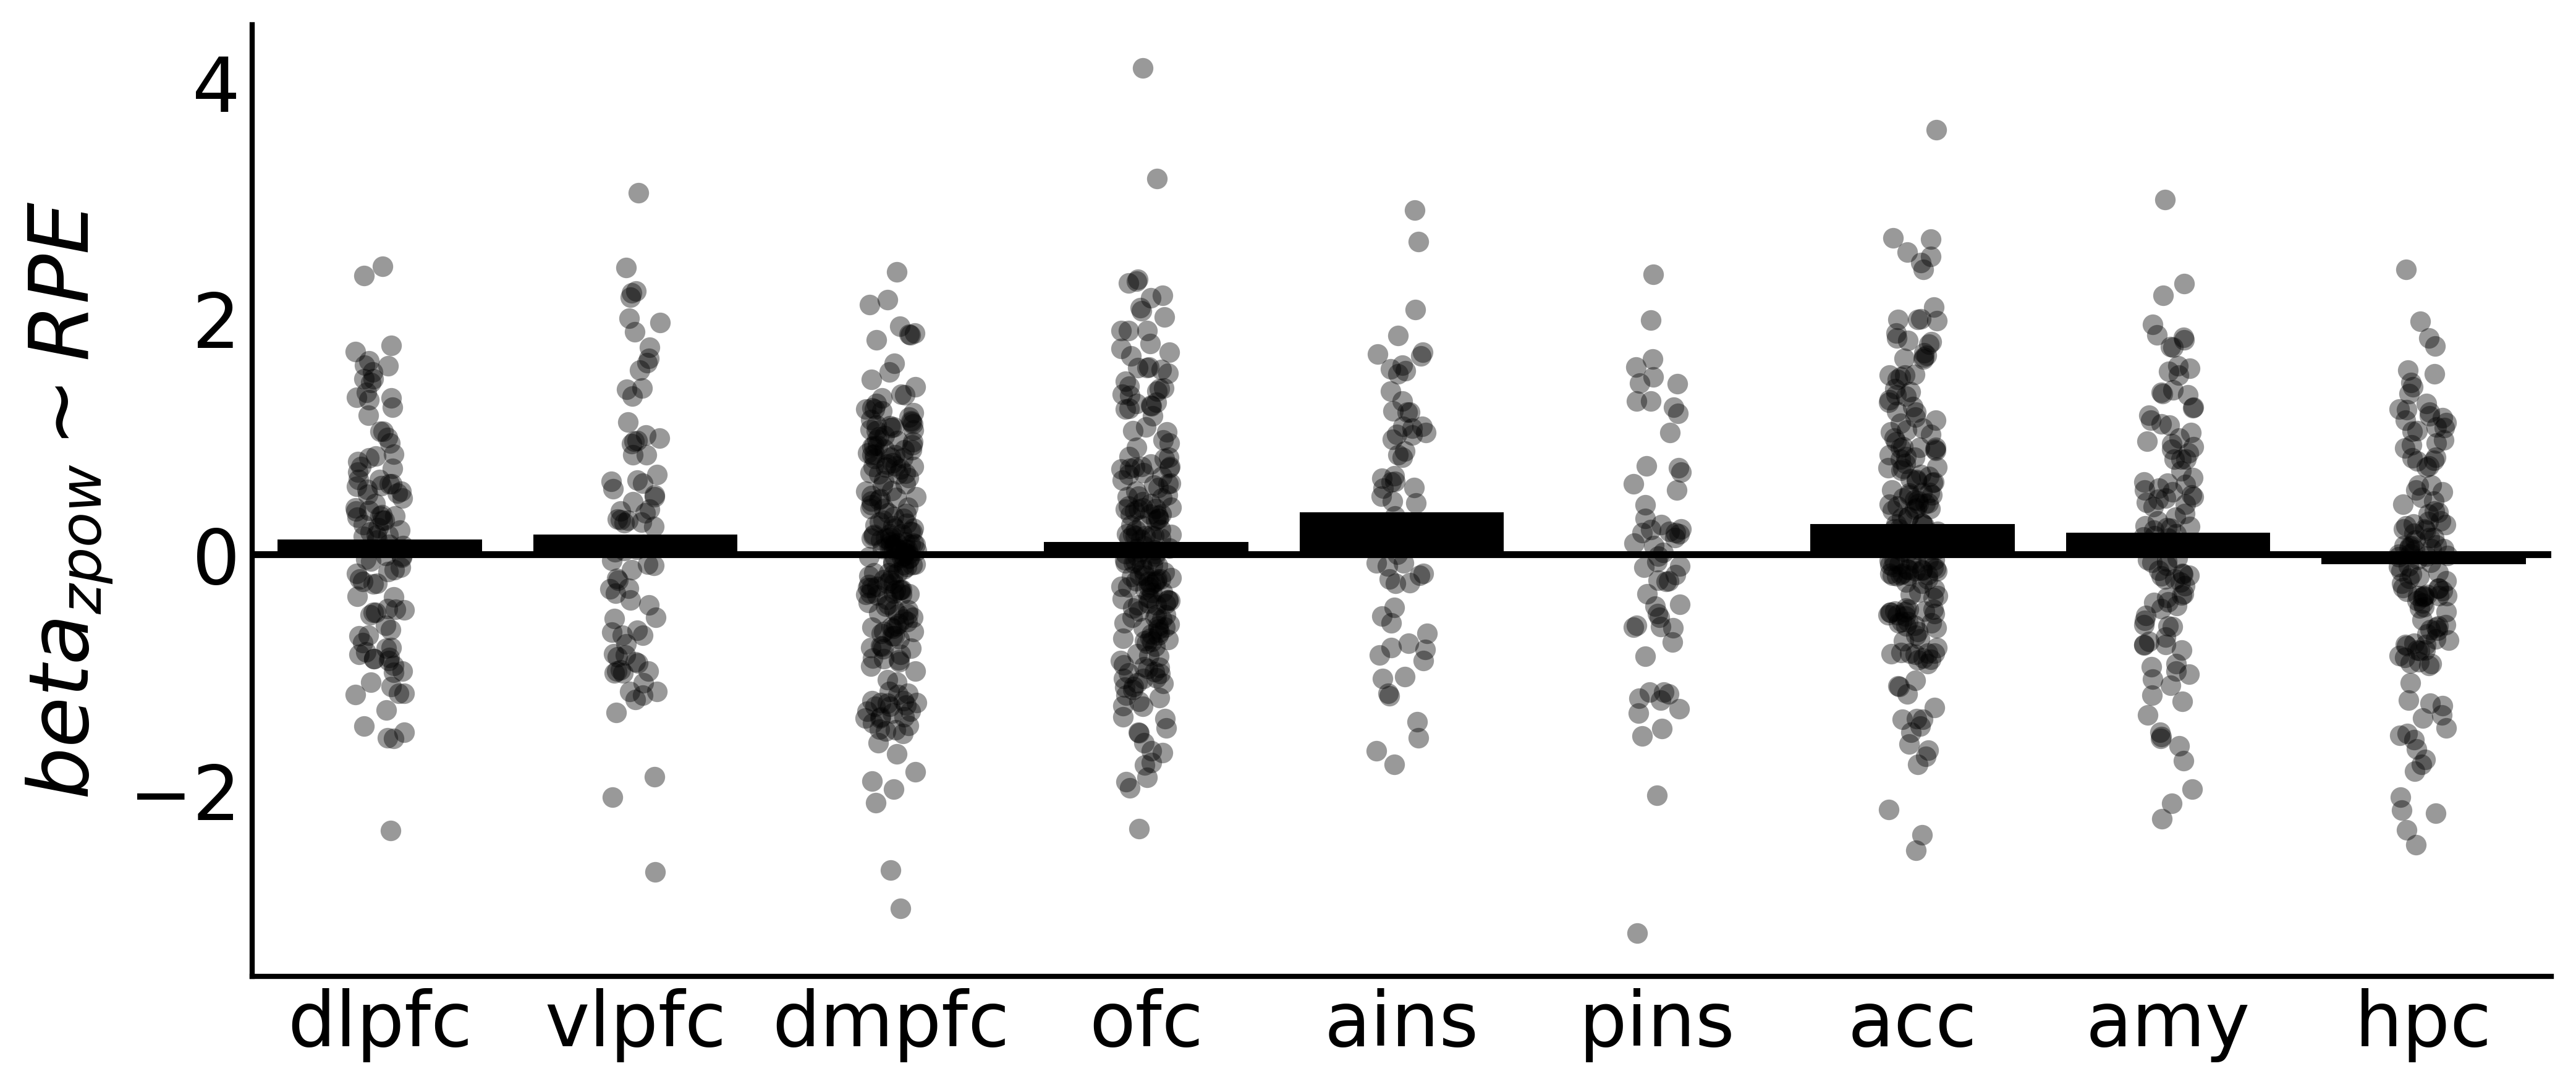

In [51]:
### WITHOUT RPE IN MODEL
plot_roi_model_results(results,'roi',rpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

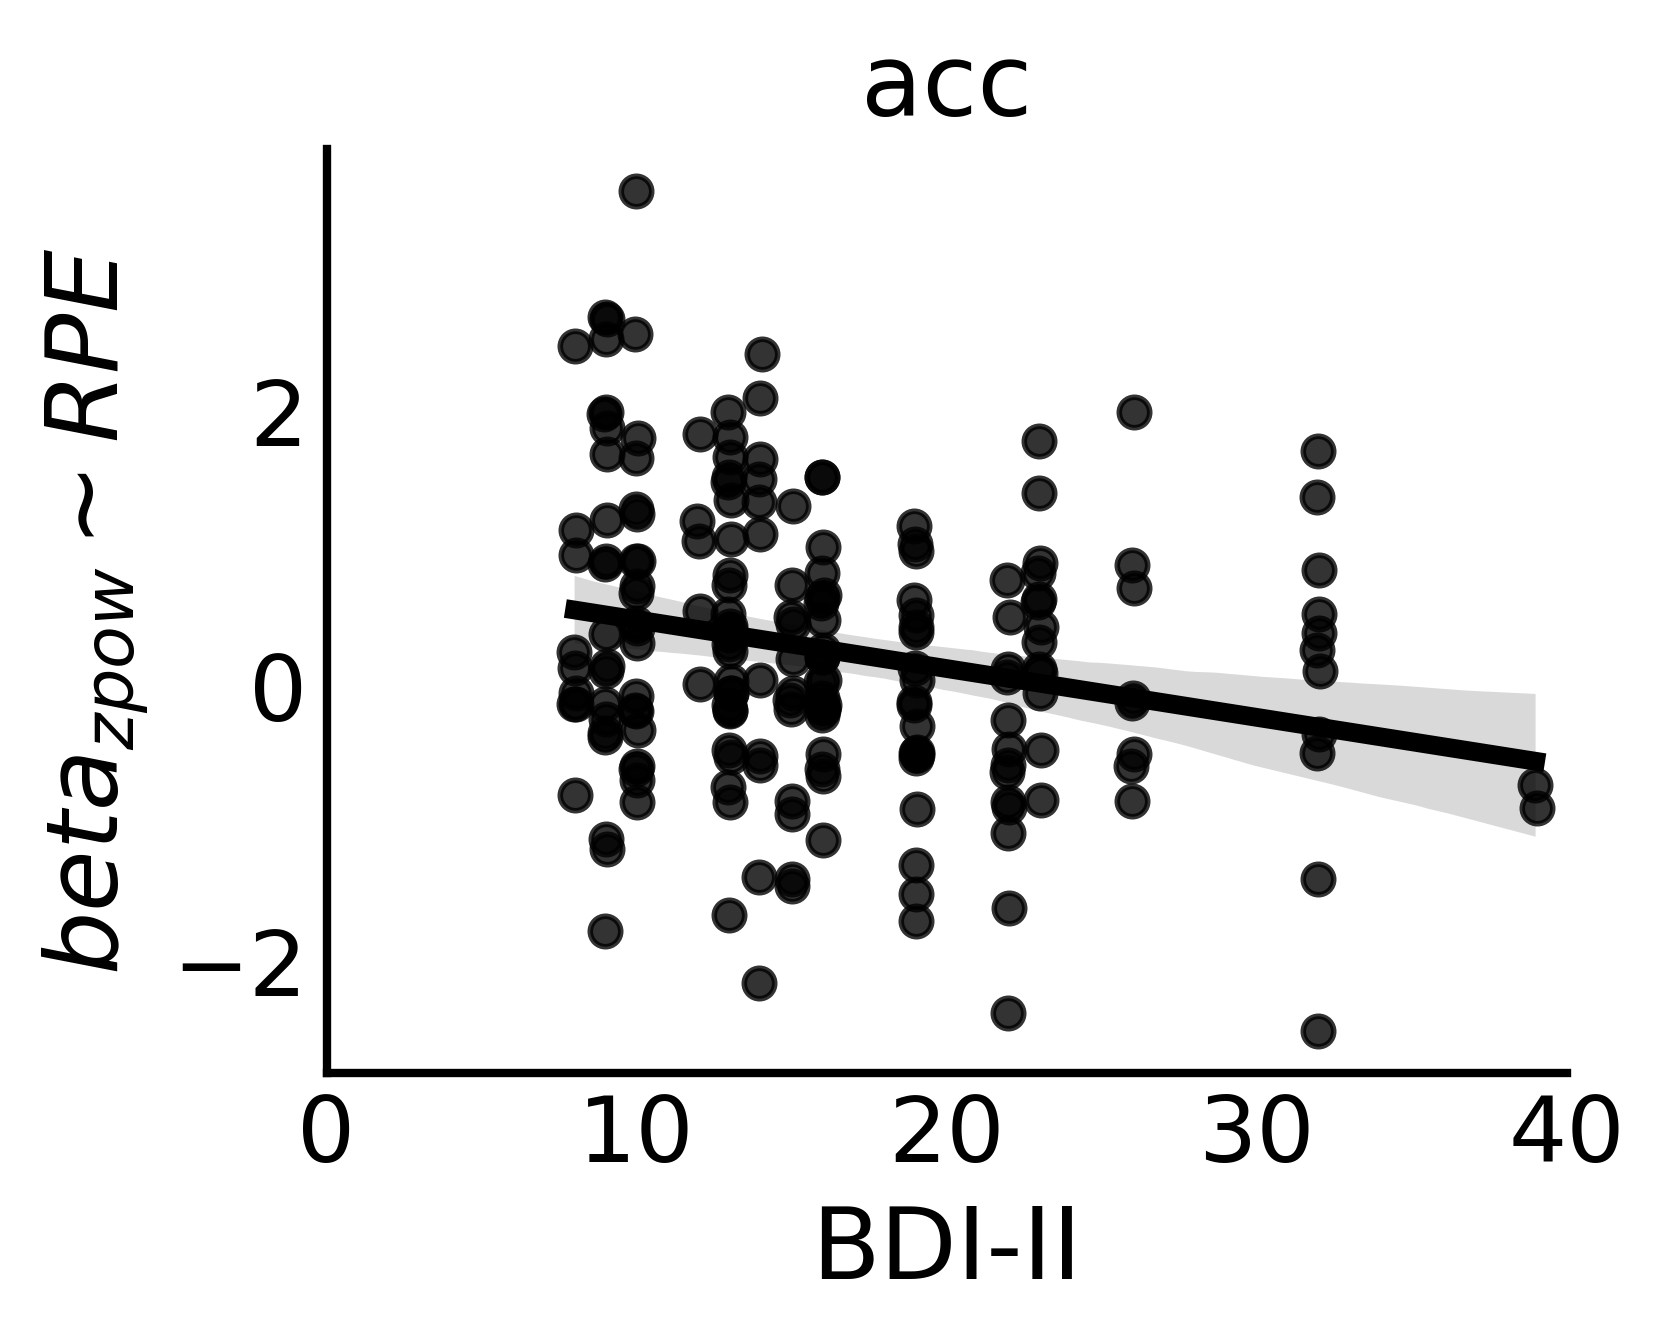

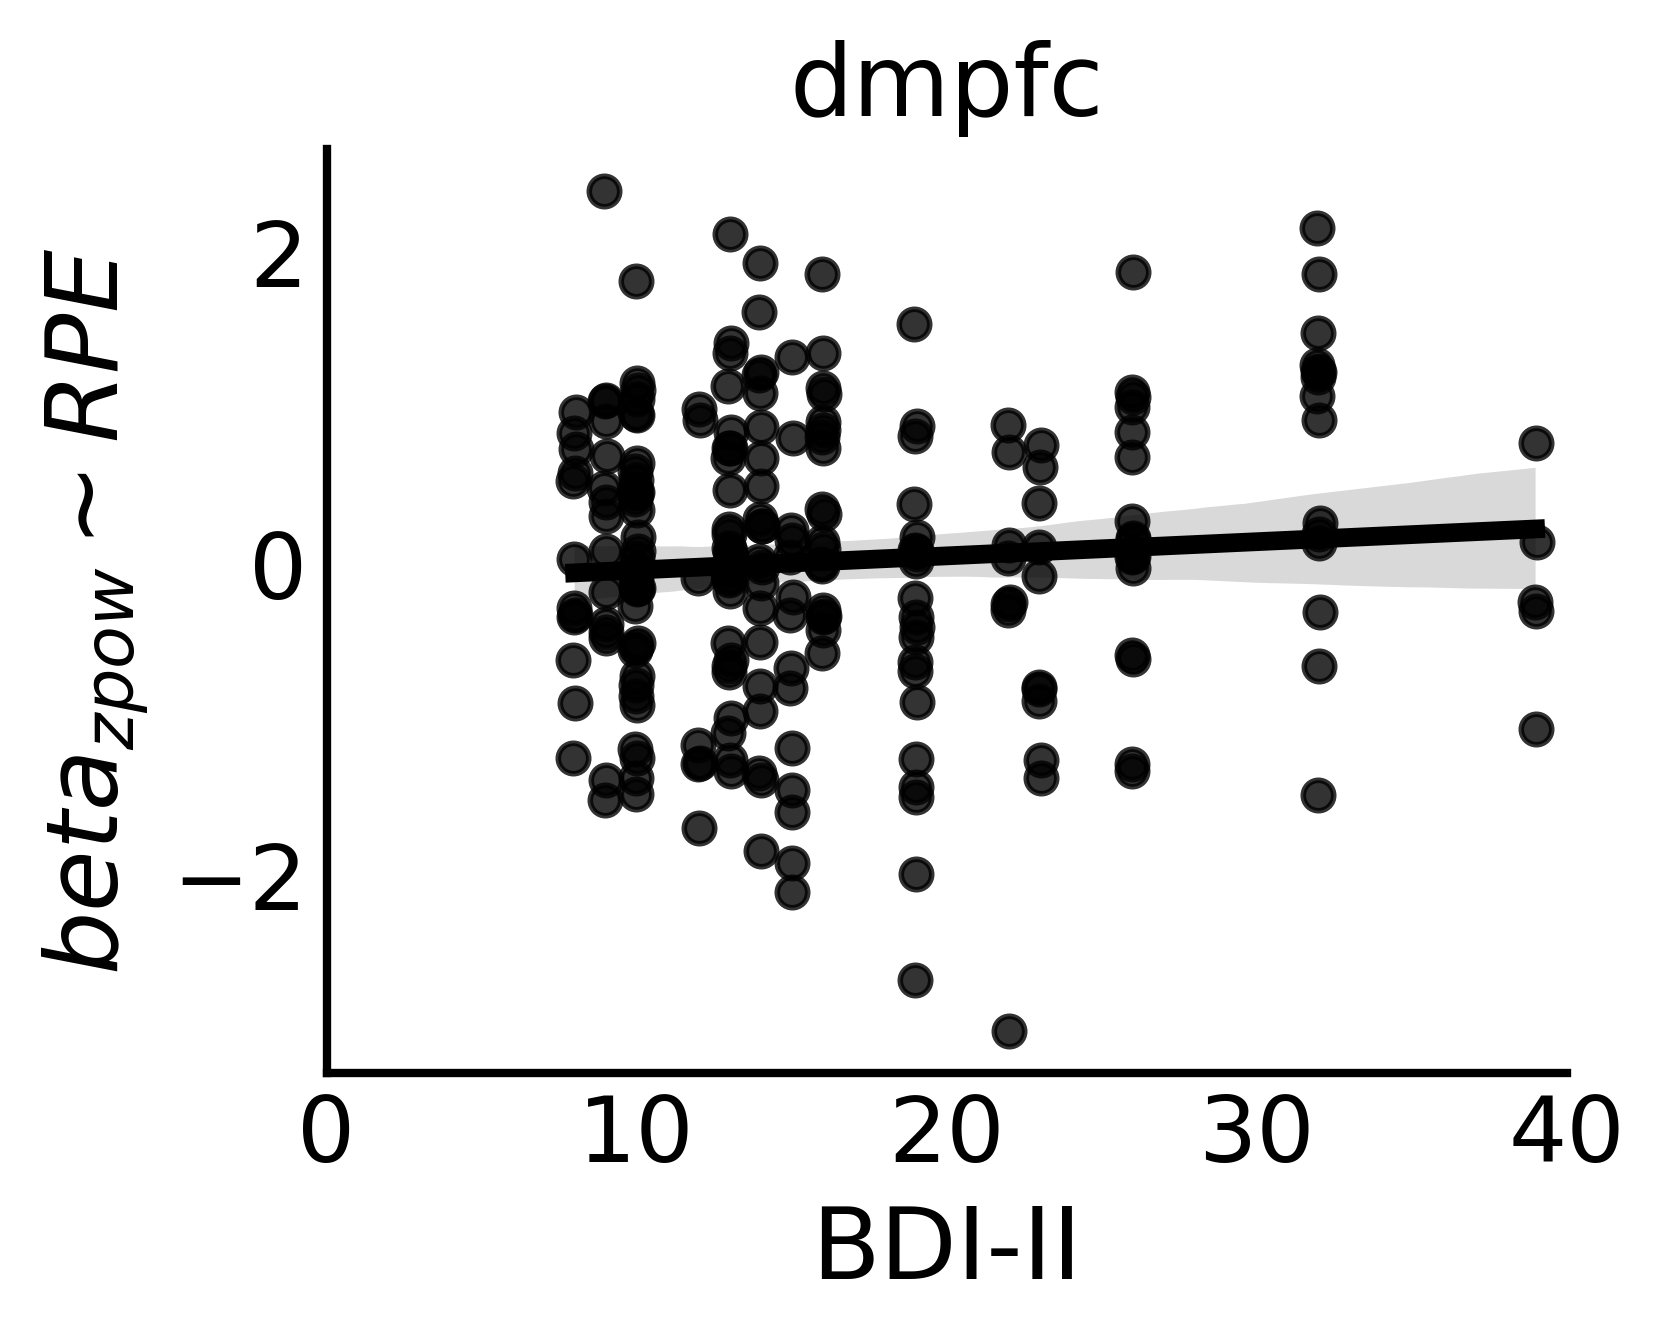

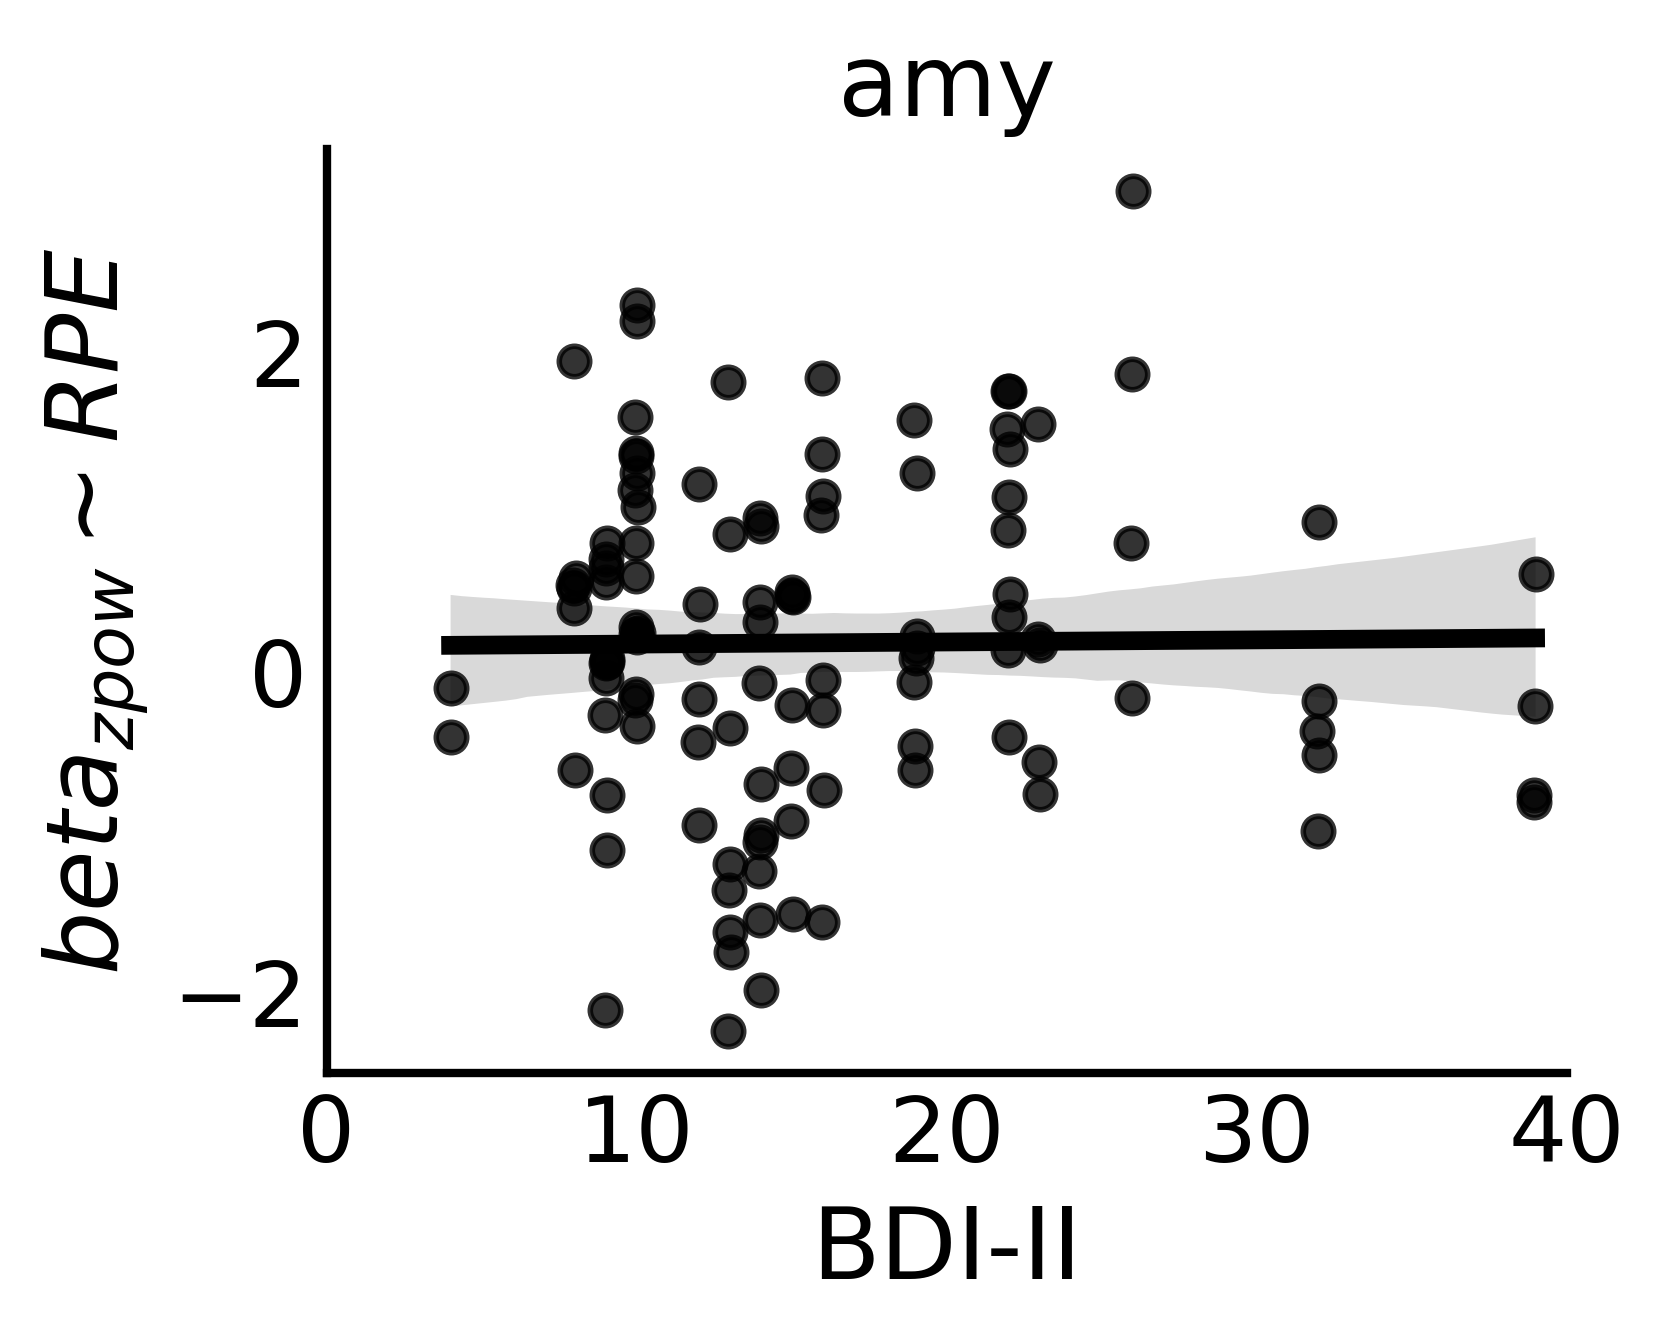

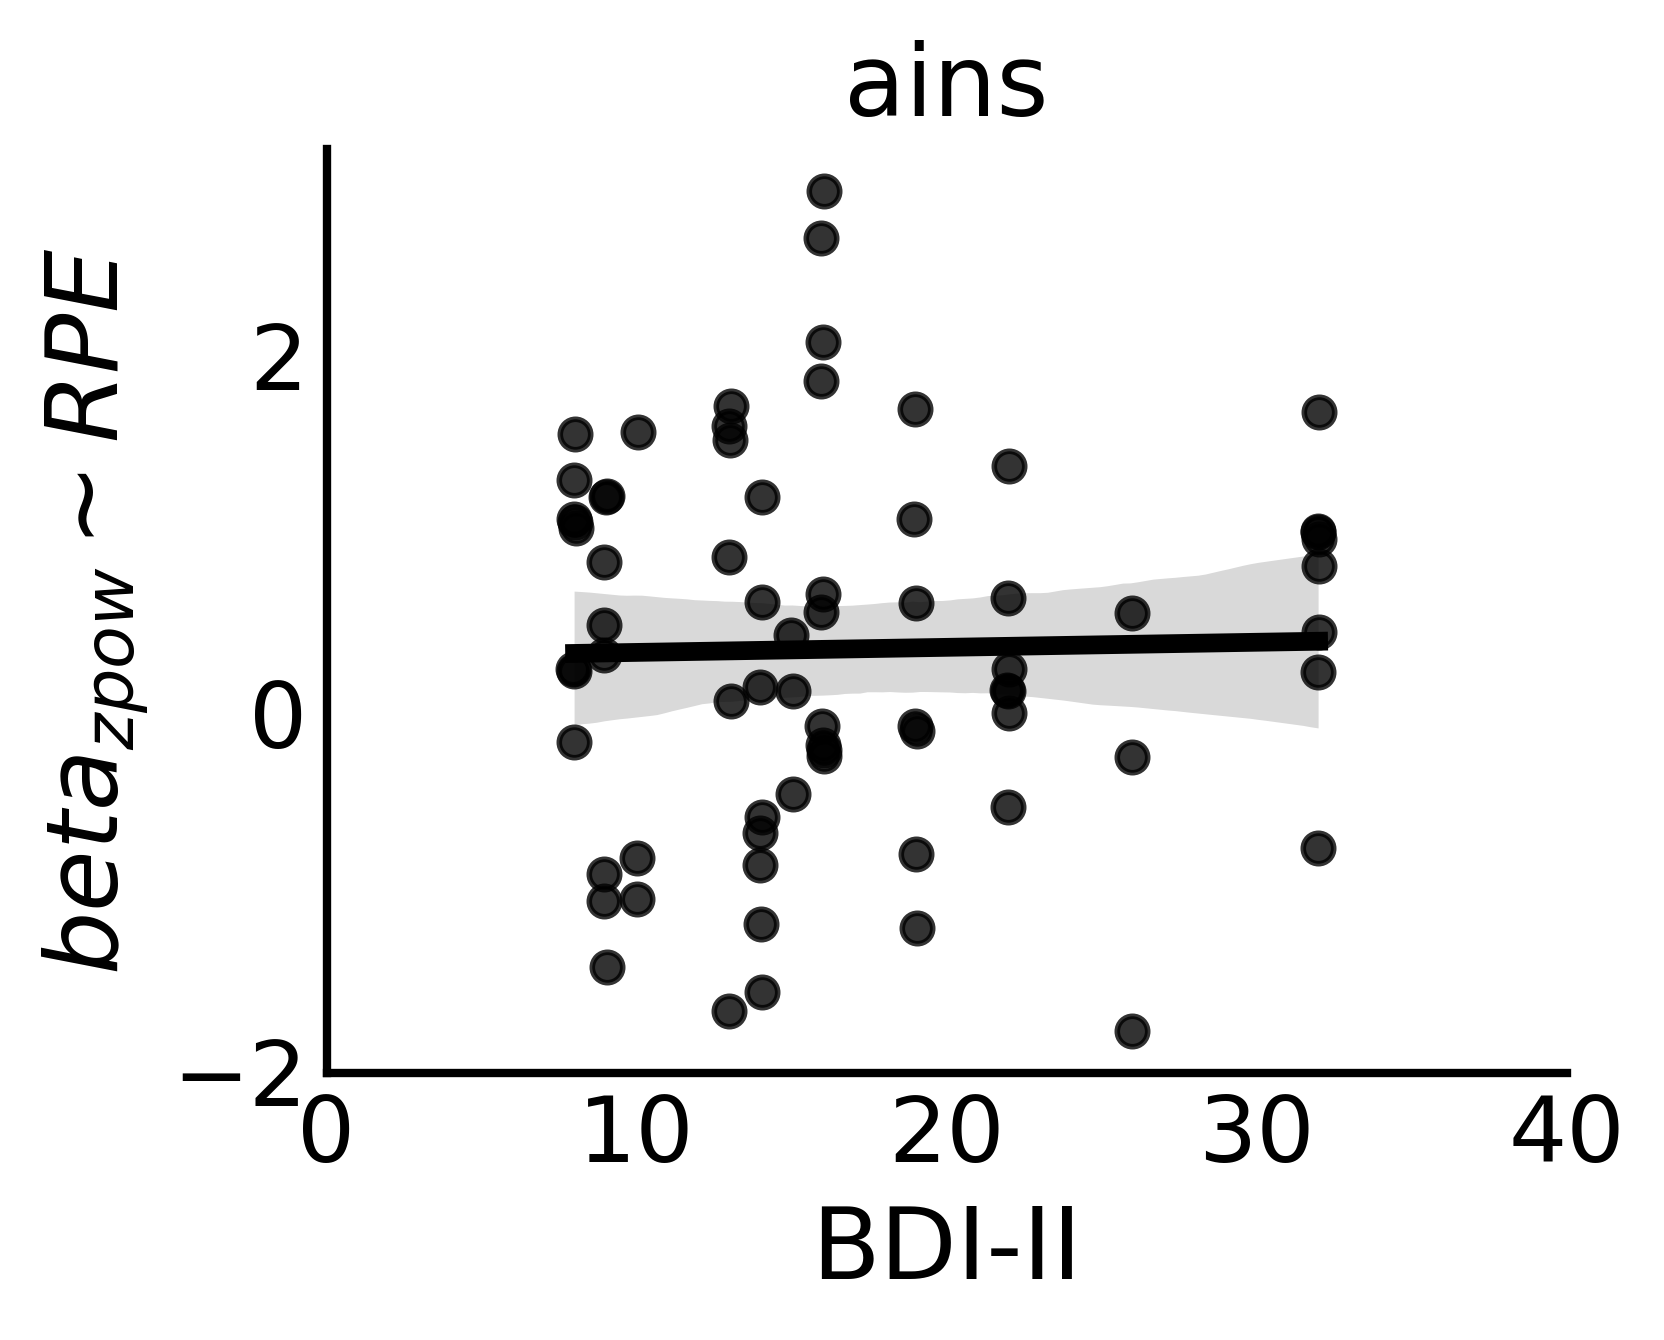

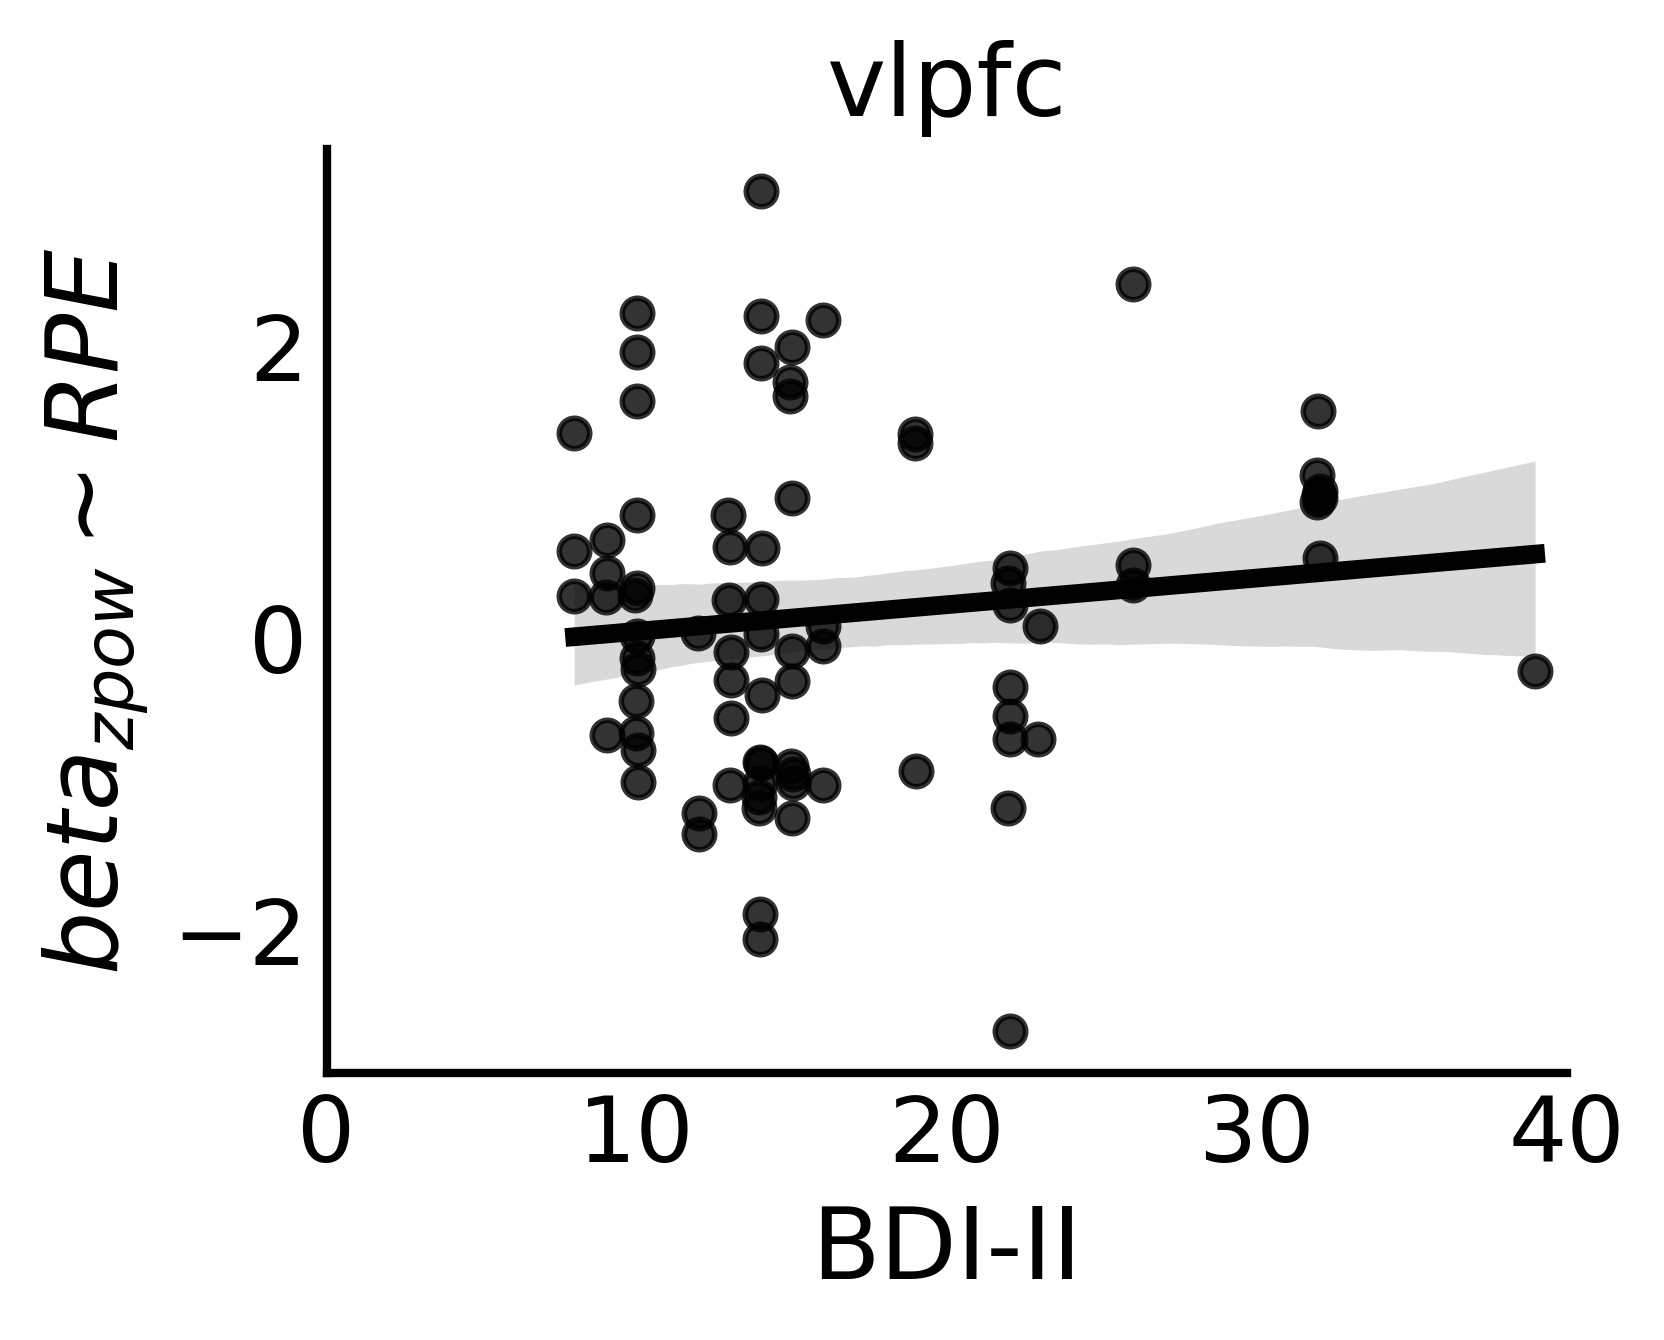

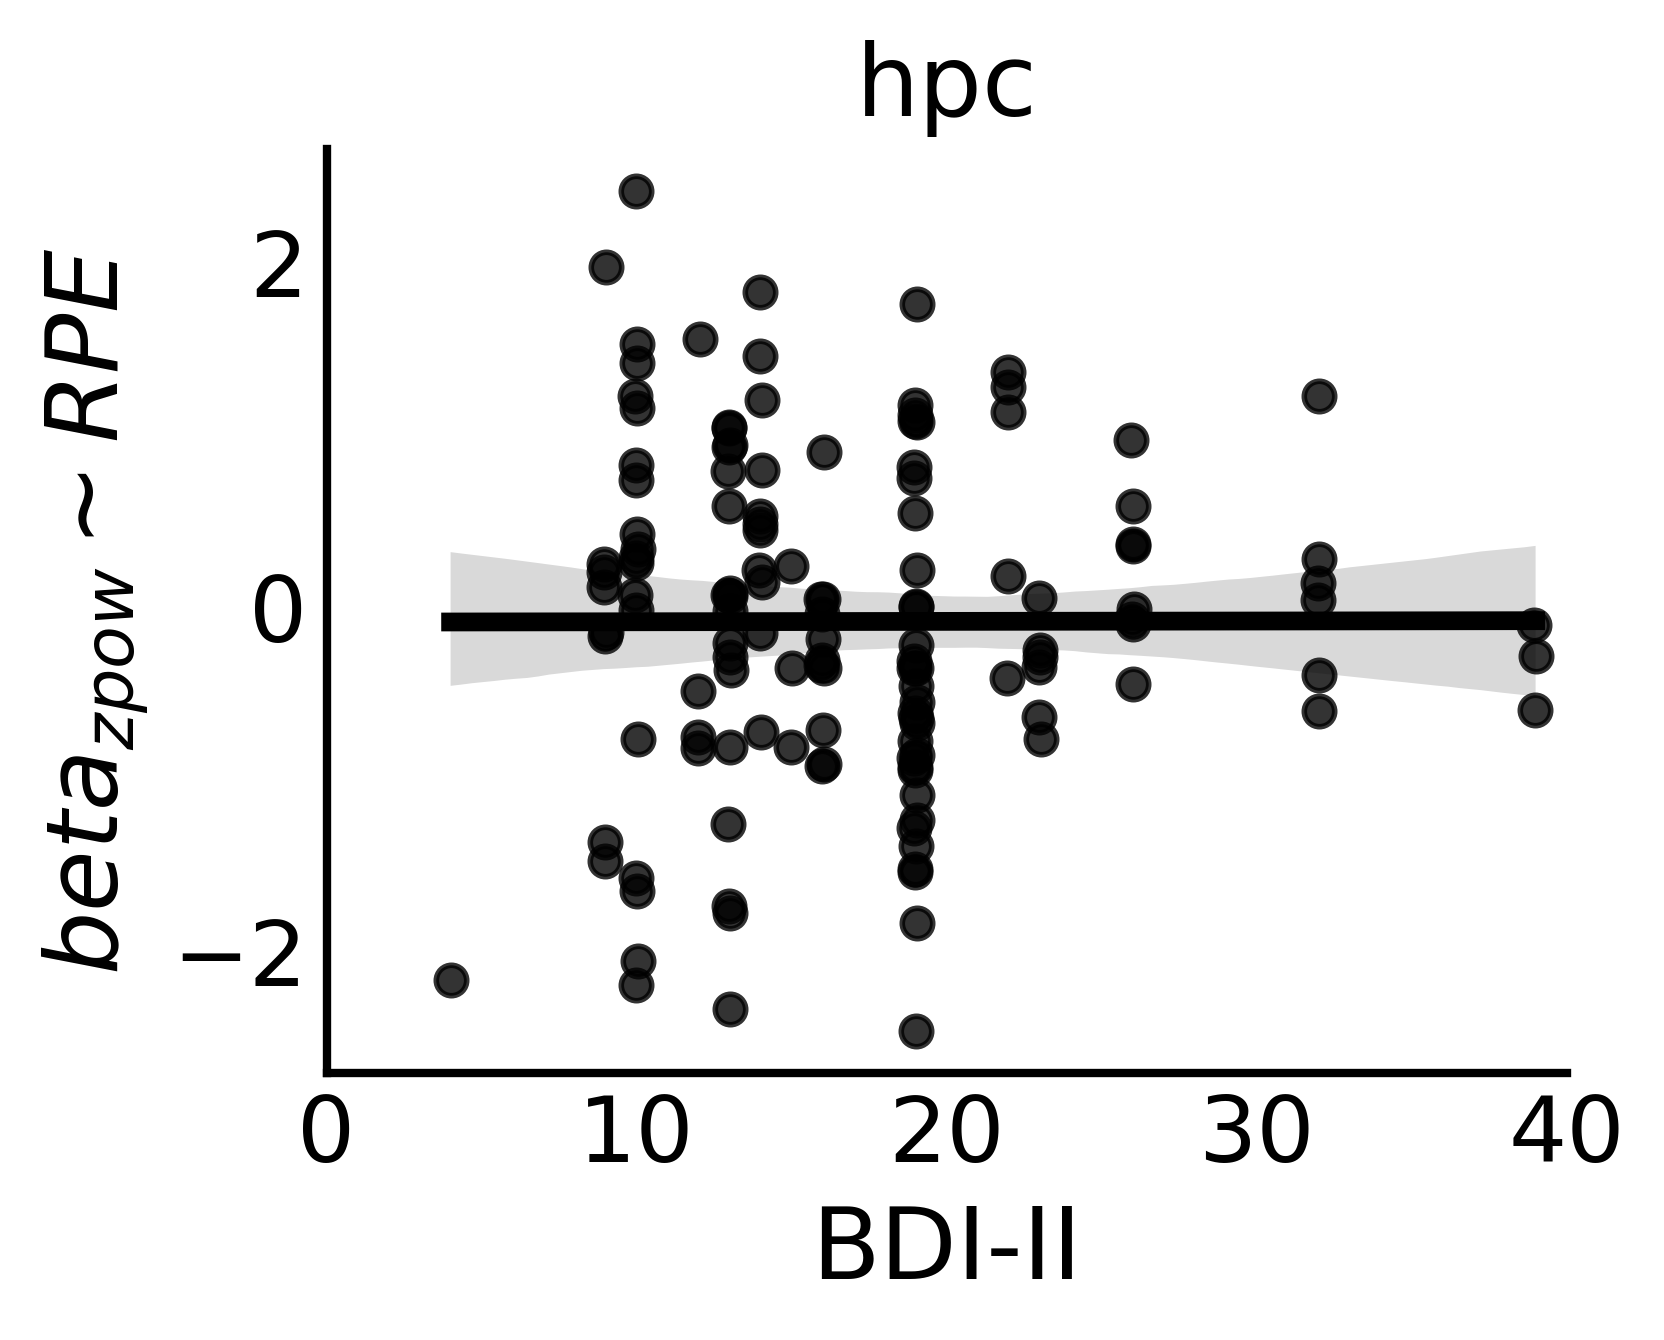

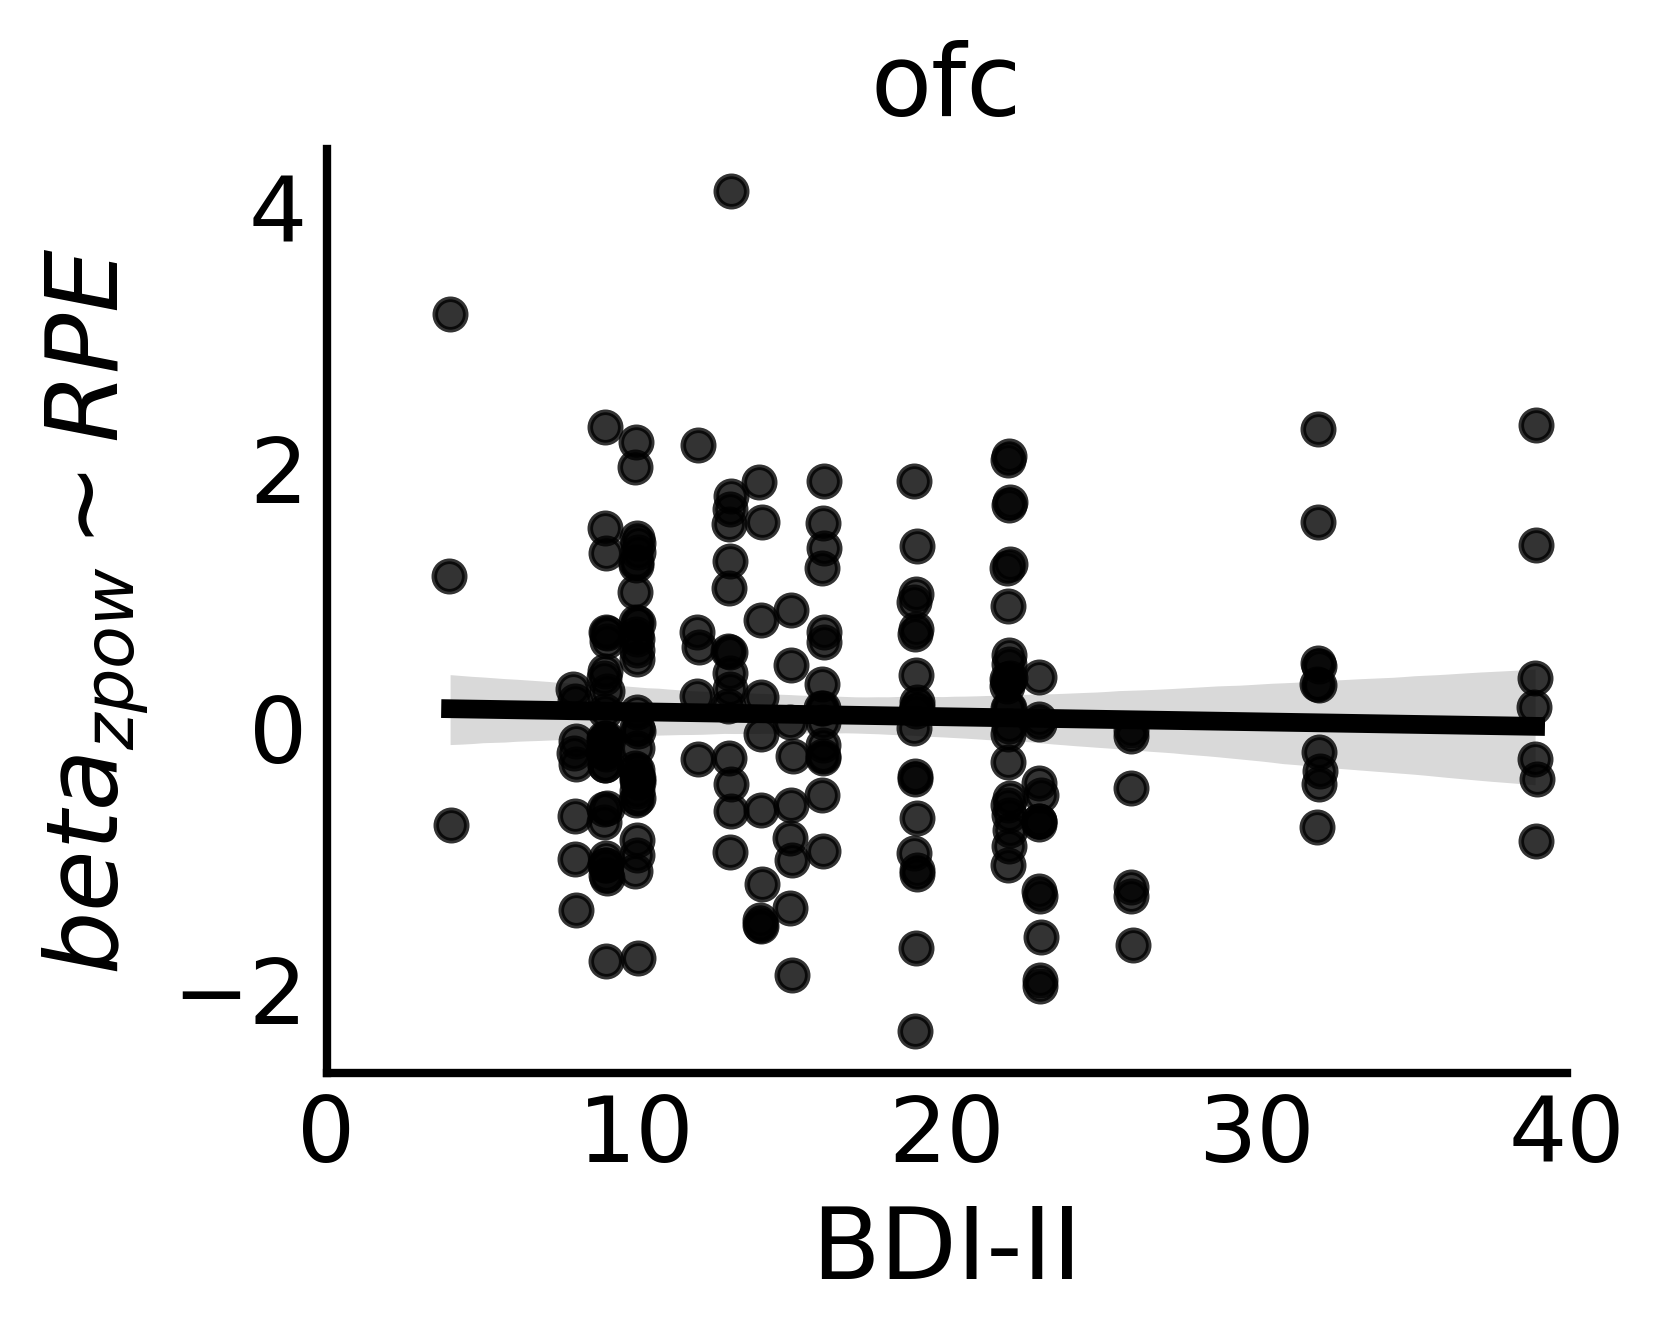

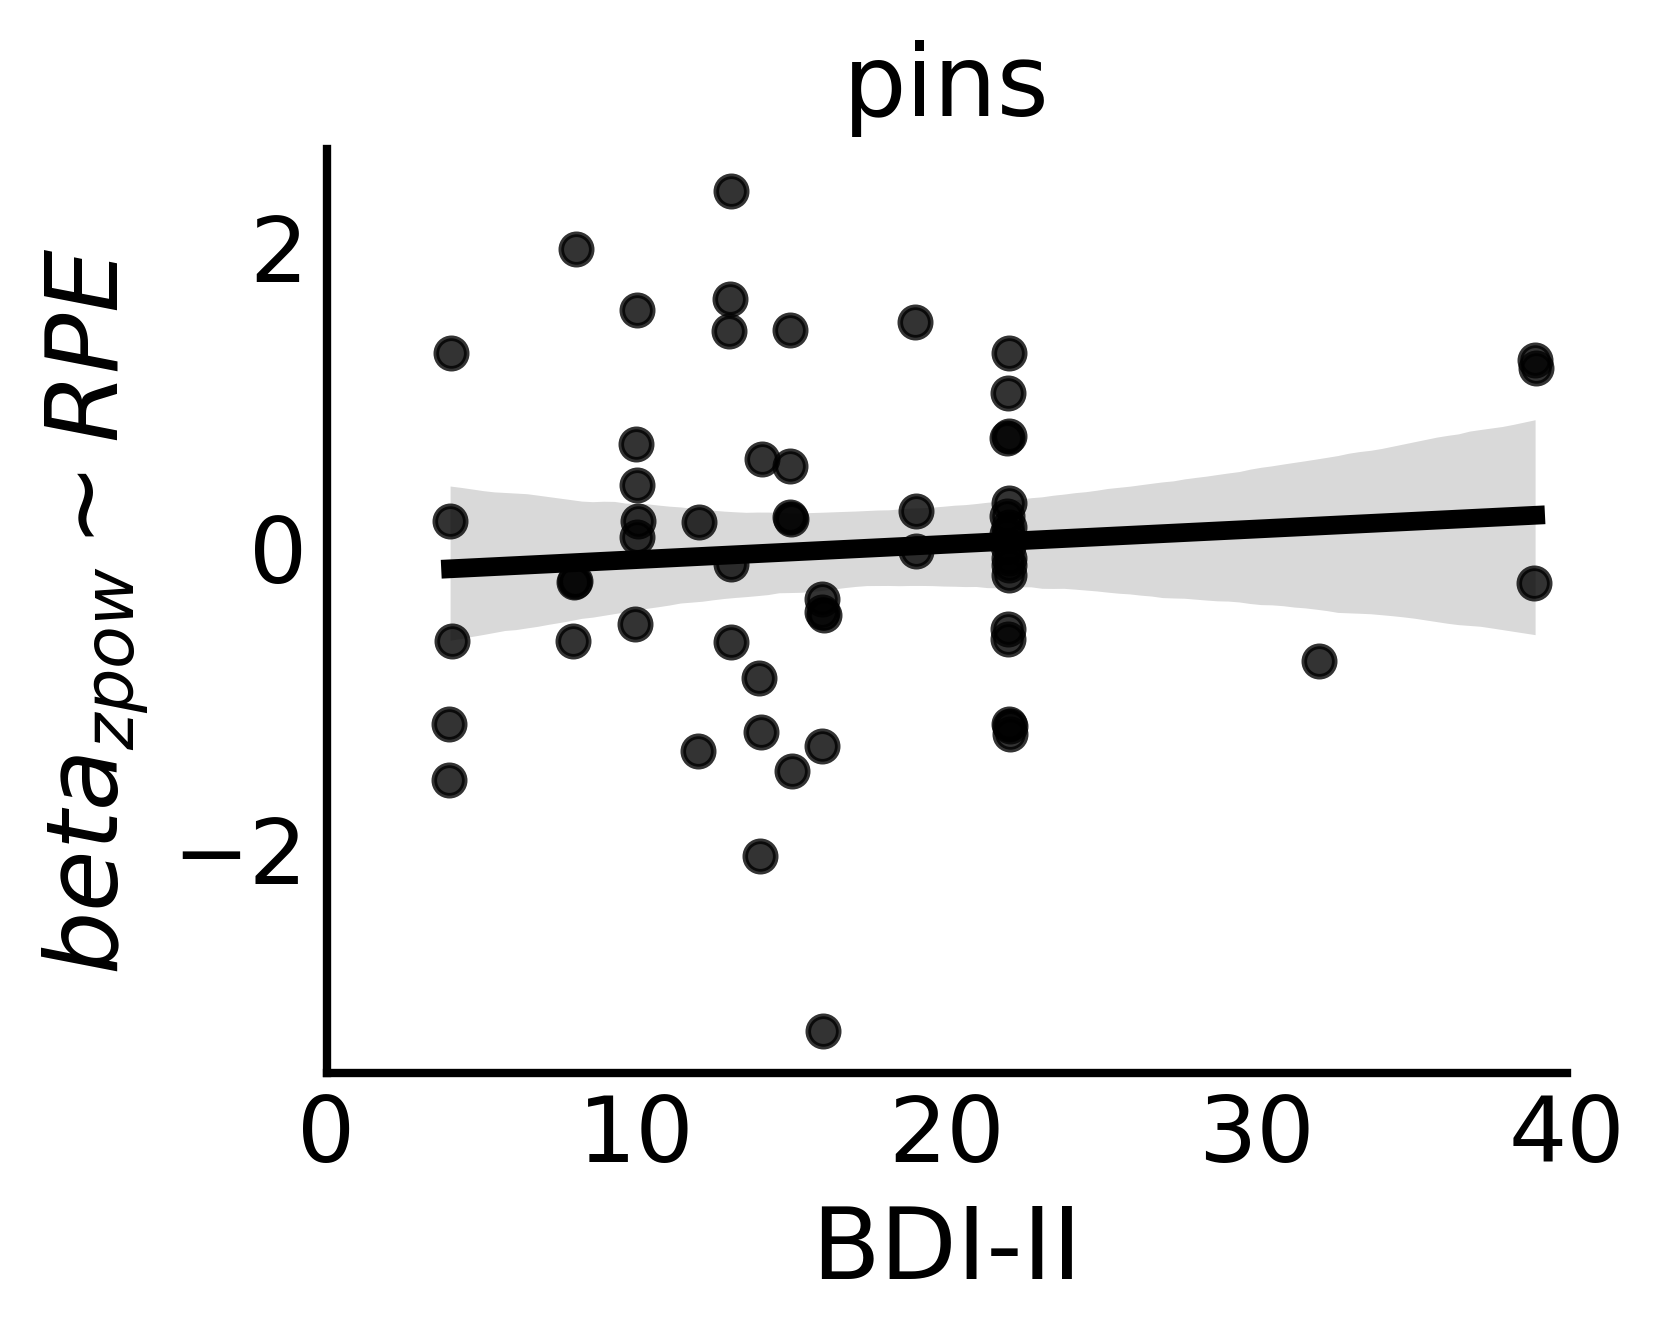

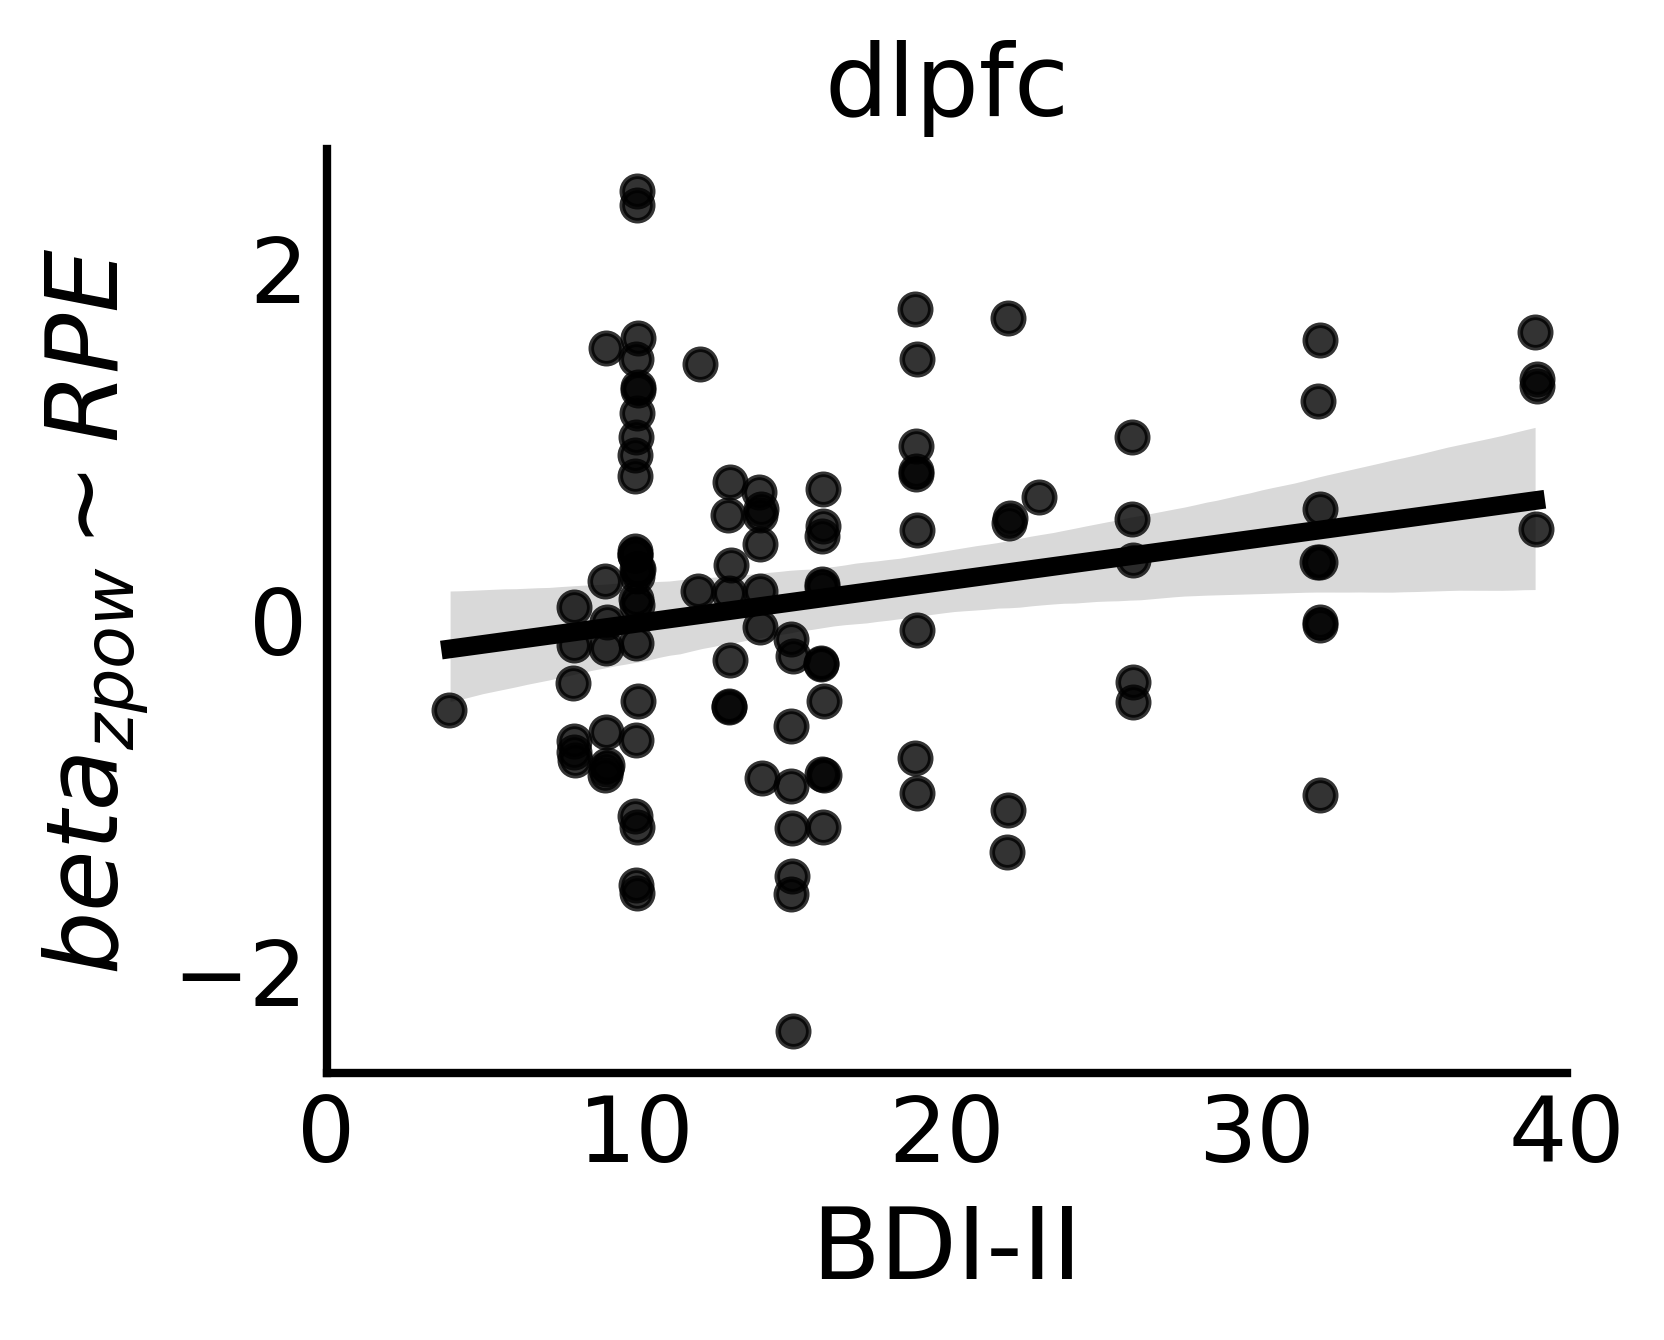

In [52]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_errormodel_RPE_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_rpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim RPE$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [53]:
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_rpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        20:35:21                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9910      0.447     35.747     